<a href="https://colab.research.google.com/github/delffine/Pet-projects/blob/main/tver_med/tver_med.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вводная часть

Это исследование обеспеченности медицинскими кадрами в Тверской области. Заказчиком выступил Тверской государственный медицинский университет.

**В ходе исследования необходимо ответить на ряд вопросов:**
- Верно ли, что наибольший «кадровый голод» первичного звена ощущается в районах, расположенных ближе к городу и наименьший – в отдаленных районах?
- В каких районах самые молодые, а в каких - самые старые врачи?
- Верно ли, что большинство медицинских работников в Тверской области пенсионного возраста?
- Верно ли, что женщин в возрасте 60+ работает меньше, чем мужчин в возрасте 60+?
- Верно ли, что женщин в возрасте 30-50 лет работает больше, чем мужчин этого же возраста?
- Верно ли, что молодые специалисты (до 35 лет) уезжают в другие регионы и не остаются работать ни в Твери, ни в районах Тверской области?
- Верно ли, что не менее 50 выпускников Университета (24-27 лет) устроились работать в этом году в систему оказания первичной врачебной медико-санитарной помощи Твери и Тверской области?
- Верно ли, что в Твери выпускников Университета устроилось работать больше, чем в области?

**Первичная врачебная медико-санитарная помощь оказывается, врачами-терапевтами участковыми, врачами-педиатрами участковыми и врачами общей практики (семейными врачами).

В распоряжение был представлен файл с данными по врачам - дата рождения, пол, специальность, место работы, а также датасет по медицинским организациям - полное и сокращенное название МО, адрес МО, географические координаты.

Допускается использовать другие любые данные, которые смогут обогатить исходные и улучшить исследование. Пожеление заказчика - результаты исследования представить на географической карте региона.

**Ход исследования:**
- Загрузка данных
- Предобработка данных
- Исследовательский анализ данных
- Поиск ответов на поставленные вопросы

# Загрузка библиотек, начальные установки, процедуры и функции

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors
from matplotlib import colormaps
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

import folium
from shapely.ops import unary_union
import geopandas as gpd

import datetime
import re
import os

In [ ]:
#!pip install fuzzywuzzy
#from fuzzywuzzy import fuzz
#нет в колабе такого модуля, а каждый раз устанавливать - лень...
#модуль делает проверку растояний Ливенштайна на неявные дубликаты

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
pd.set_option('display.max_colwidth', 1000)

## Процедуры и функции

In [ ]:
#Функиця расчета возраста на сегодня из даты рождения
def calculate_age(born):
    today = datetime.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [ ]:
#Функция определения специальностей первичного звена
def prim_stat(prof):
    st = 0
    if prof == 'врач-терапевт участковый' or prof == 'врач-педиатр участковый' or prof == 'врач общей практики (семейный врач)': st = 1
    return st

In [ ]:
#Функция определения пенсионного возраста
#В 2024 году пенсионный возраст в России для женщин составляет 58 лет, а для мужчин — 63 года
def pensioner(row):
    pens = 'Не пенсионер'
    if (row['gender'] == 'Муж.') & (row['age'] >= 63): pens = 'Пенсионер'
    if (row['gender'] == 'Жен.') & (row['age'] >= 58): pens = 'Пенсионер'
    return pens

In [ ]:
# Процедура поиска неявных дубликатов по расстоянию Левенштайна из базлайна
# Функция выичисляет расстояния Левенштейна и выводит совпадения 99% и более.
def fuzz_mo(data, col):
    """
# Чтобы уменьшить число проверок будем проверять название МО
# со всеми следующими за ним названия МО.
# Получаем значение и индекс.
    """
    for med_ind, med_inst_1 in enumerate(data[col].unique()):
        # Проверяем, чтобы индекс не был последним.
        if (data[col].nunique()-1) != med_ind:
            # Запускаем цикл по проверке расстояния Левенштейна.
            for med_inst_2 in data[col].unique()[(med_ind+1):]:
                if fuzz.ratio(med_inst_1, med_inst_2) >= 99:
                    # Вывод данных при совпадении условий.
                    print(med_inst_1)
                    print(med_inst_2)
                    print(50*'*')
    return


In [ ]:
#Функция списка градиентов цвета в зависимости от входной величины
def gradient_by_value(col = pd.Series([]), gradient = plt.cm.RdYlGn_r):
    norm = TwoSlopeNorm(vmin=col.min(), vcenter=col.mean(), vmax=col.max())
    gradient = [rgba2hex(gradient(norm(c))) for c in col]
    return gradient

In [ ]:
#Цвет RGB в HEX
def rgba2hex(rgba):
    r = int(rgba[0] * 255)
    g = int(rgba[1] * 255)
    b = int(rgba[2] * 255)
    return f'#{r:02x}{g:02x}{b:02x}'

In [ ]:
#Функция цветов градиента для ячеек таблицы, исходя из всех данных в таблице
def background_gradient_alltable(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in colormaps[cmap](normed)]
    return ['background-color: %s' % color for color in c]

In [ ]:
#Процедура преобразования полигонов из формата geopandas в формат DataLens
def bi_format(x):
    '''функция для перевода из wkt в формат для BI'''
    x = str(x)
    #if x.find("MULTIPOLYGON") != -1:
    if "MULTIPOLYGON" in x:
        return x.replace('MULTIPOLYGON','')\
        .strip()\
        .replace(', ','],[')\
        .replace('(','[')\
        .replace(')',']')\
        .replace(']]],[[[',']],[[')\
        .replace(' ',',')
    elif 'POLYGON' in x:
    #elif x.find("POLYGON") != -1:
        return '[' + x.replace('POLYGON','')\
        .strip()\
        .replace(', ','],[')\
        .replace('(','[')\
        .replace(')',']')\
        .replace(']]],[[[',']],[[')\
        .replace(' ',',') + ']'
    return x

# Загрузка данных

In [ ]:
#Данные для аналза хранятся в excel файле на google.disc
#Подлючаем google.disc как папку
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/tver_med/'):
  from google.colab import drive
  drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/tver_med/

/content/drive/My Drive/Colab Notebooks/tver_med


In [ ]:
dir = ''
data_path = dir + 'tver_med_data.xlsx'

In [ ]:
#Таблица сотрудников
staff = pd.read_excel(data_path, sheet_name='Сотрудники')

In [ ]:
#Таблица мед организаций
coord = pd.read_excel(data_path, sheet_name='Координаты')

In [ ]:
staff.head()

Unnamed: 0 Дата рождения  Возраст   Пол  \
0           1    1958-01-01       66  Муж.   
1           2    1968-11-13       55  Жен.   
2           3    1950-02-01       74  Муж.   
3           4    1957-02-08       67  Муж.   
4           5    1974-11-14       49  Жен.   

                                                                                               Организация по основной должности  \
0   ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ОБЛАСТНОЙ КЛИНИЧЕСКИЙ ПСИХОНЕВРОЛОГИЧЕСКИЙ ДИСПАНСЕР"   
1                       ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "СТОМАТОЛОГИЧЕСКАЯ ПОЛИКЛИНИКА №1"   
2  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "КАЛИНИНСКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ КЛИНИЧЕСКАЯ БОЛЬНИЦА"   
3   ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "ОБЛАСТНОЙ КЛИНИЧЕСКИЙ ПСИХОНЕВРОЛОГИЧЕСКИЙ ДИСПАНСЕР"   
4         ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "КЛИНИЧЕСКАЯ БОЛЬНИЦА СКОРОЙ МЕДИЦИНСКОЙ ПОМОЩИ"   

                    Основная должность  
0       Врач-анестезиолог-реаниматолог  
1                     Рентгенолаборант  
2  Врач общей практики (семейный врач)  
3       Врач-анестезиолог-реаниматолог  
4  врач общей практики (семейный врач)

In [ ]:
staff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419 entries, 0 to 1418
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Unnamed: 0                         1419 non-null   int64         
 1   Дата рождения                      1419 non-null   datetime64[ns]
 2   Возраст                            1419 non-null   int64         
 3   Пол                                1419 non-null   object        
 4   Организация по основной должности  1414 non-null   object        
 5   Основная должность                 1414 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 66.6+ KB


In [ ]:
coord.head()

Организация по основной должности  \
0                            АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ТВЕРСКОЙ ОБЛАСТИ "МЕДИЦИНСКИЙ ЦЕНТР "БЕЛАЯ РОЗА"   
1                                                     АКЦИОНЕРНОЕ ОБЩЕСТВО "КОНАКОВСКИЙ ЗАВОД СТАЛЬНЫХ КОНСТРУКЦИЙ"   
2  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ  УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "КАШИНСКАЯ СТОМАТОЛОГИЧЕСКАЯ ПОЛИКЛИНИКА"   
3  ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ  УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "КАШИНСКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ БОЛЬНИЦА"   
4   ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ  УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ "КИМРСКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ БОЛЬНИЦА"   

  Сокращенное название организации                  Округ/район  \
0                 АНО "БЕЛАЯ РОЗА"  городской округ город Тверь   
1                       АО  "КЗСК"            Конаковский район   
2              ГБУЗ "КАШИНСКАЯ СП"    Кашинский городской округ   
3             ГБУЗ "КАШИНСКАЯ ЦРБ"    Кашинский городской округ   
4              ГБУЗ "КИМРСКАЯ ЦРБ"  городской округ город Кимры   

                                                           Адрес  \
0  170100, Тверская область, город Тверь, Тверской пр-кт, д. 14    
1   171252, Тверская область, г. Конаково, ул. Промышленная, д.1   
2         Тверская область, г. Кашин, ул. Карла Маркса, д. 24/23   
3          171640, Тверская область, г. Кашин, ул. Вонжинская, 2   
4   171502, Тверская область, г. Кимры, Борковское шоссе, дом 10   

                              Координаты  
0  56.86053266726136, 35.909560612319325  
1   56.72231762064035, 36.78252888653642  
2   57.355114792071056, 37.6091387505305  
3  57.35759162268202, 37.622431951037704  
4   56.83610336308383, 37.36593272292891

In [ ]:
coord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 5 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Организация по основной должности  113 non-null    object
 1   Сокращенное название организации   113 non-null    object
 2   Округ/район                        113 non-null    object
 3   Адрес                              113 non-null    object
 4   Координаты                         113 non-null    object
dtypes: object(5)
memory usage: 4.5+ KB


## Бонус-данные

In [ ]:
#Население по территориям Тверской области
#На основе данных Росстата на 1 января 2024
#https://69.rosstat.gov.ru/folder/26784
tver_pop = pd.read_excel(dir + 'tver_population.xlsx')

In [ ]:
#Полигоны территорий из GeoPandas
tver_geo = gpd.read_file(dir + 'tver_geo.gpkg')

In [ ]:
#совмещаем датасеты населения и полигонов из GeoPandas по territory_id
tver_geo['territory_id'] = tver_geo['territory_id'].astype('int')
tver_pop = pd.merge(tver_pop, tver_geo[['territory_id', 'geometry']], how='left', on='territory_id')

#объединянем тверь и калининкий район, торжжок и торжокский район
tver_pop.loc[34, 'geometry'] = gpd.GeoSeries(unary_union([tver_geo.loc[3, 'geometry'], tver_geo.loc[6, 'geometry']]))[0]
tver_pop.loc[33, 'geometry'] = gpd.GeoSeries(unary_union([tver_geo.loc[4, 'geometry'], tver_geo.loc[27, 'geometry']]))[0]

# Предобработка данных

In [ ]:
#переименовываем колонки
staff.columns = ('id', 'dob', 'age', 'gender', 'org', 'prof')
coord.columns = ('org', 'org_name', 'region', 'adres', 'coord')

## Проверка на пропуски

In [ ]:
staff.isna().sum()/len(staff)

id        0.000000
dob       0.000000
age       0.000000
gender    0.000000
org       0.003524
prof      0.003524
dtype: float64

В таблице сотрудников есть пять пропусков в колонках организация и специальность

In [ ]:
staff[staff['org'].isna()]

id        dob  age gender  org prof
180    181 1958-01-26   66   Муж.  NaN  NaN
565    566 1981-03-28   43   Жен.  NaN  NaN
736    737 1982-02-06   42   Муж.  NaN  NaN
928    929 1985-07-28   39   Жен.  NaN  NaN
1405  1406 1996-03-05   28   Жен.  NaN  NaN

Ничего с ними сделать нельзя - просто удаляем

In [ ]:
staff = staff.dropna()

In [ ]:
coord.isna().sum()

org         0
org_name    0
region      0
adres       0
coord       0
dtype: int64

В таблице медорганизация пропусков нет

## Проверка на дубликаты

In [ ]:
staff[staff.duplicated()]

Empty DataFrame
Columns: [id, dob, age, gender, org, prof]
Index: []

In [ ]:
coord[coord.duplicated()]

Empty DataFrame
Columns: [org, org_name, region, adres, coord]
Index: []

Полных дубликатов нет

In [ ]:
#fuzz_mo(staff, 'org')

Неявных дубликатов в названиях медорганизаций - тоже нет

## Преобразовние колонок, создание новых вспомогательных колонок

In [ ]:
#актульный на сегодня возраст из дня рождения
staff['age'] = staff['dob'].apply(calculate_age)

In [ ]:
#пенсионер
staff['pens'] = staff.apply(pensioner, axis=1)

In [ ]:
#профессию в нижний регистр
staff['prof'] = staff['prof'].str.lower()

In [ ]:
#первичное звено
staff['prim'] = staff['prof'].apply(prim_stat)

In [ ]:
#Переводим координаты МО в массив и строчку для ДЛ
coord['coord_m'] = coord['coord'].apply(lambda x: x.split(', '))
coord['coord_s'] = coord['coord'].apply(lambda x: '['+x+']')

In [ ]:
#ТИП организации
coord['org_type'] = coord['org_name'].apply(lambda x: x.upper().split(' ')[0])

In [ ]:
#Названия территорий короче и чтобы первым шло имя
coord['region'] = coord['region'].replace(
        {'городской округ город ': '',
         'Городской округ ЗАТО Солнечный': 'Солнечный ЗАТО',
         'Городской округ ЗАТО Озёрный': 'Озёрный ЗАТО',
        }, regex=True)

## Объединение таблиц сотрудников и организаций в общий датасет

In [ ]:
data = pd.merge(staff, coord, how='left', on='org')

In [ ]:
#Удаляем колонки с полным названием организации и датой рождения
data = data.drop(['org', 'dob', 'coord'], axis = 1)

In [ ]:
data = data.reset_index(drop = True)

In [ ]:
data.head()

id  age gender                                 prof          pens  prim  \
0   1   67   Муж.       врач-анестезиолог-реаниматолог     Пенсионер     0   
1   2   56   Жен.                     рентгенолаборант  Не пенсионер     0   
2   3   74   Муж.  врач общей практики (семейный врач)     Пенсионер     1   
3   4   67   Муж.       врач-анестезиолог-реаниматолог     Пенсионер     0   
4   5   50   Жен.  врач общей практики (семейный врач)  Не пенсионер     1   

             org_name region                                   adres  \
0  ГБУЗ Окпнд г Тверь  Тверь  170005, г. Тверь, ул. Фурманова, д. 12   
1        ГБУЗ "СП №1"  Тверь      170001, г. Тверь, ул. Бакунина, 33   
2        ГБУЗ "КЦРКБ"  Тверь      170032, Тверь, п. Химинститута, 59   
3  ГБУЗ Окпнд г Тверь  Тверь  170005, г. Тверь, ул. Фурманова, д. 12   
4        ГБУЗ "КБСМП"  Тверь     170024, г. Тверь, ул. М. Конева, 71   

                                    coord_m  \
0  [56.871230795727044, 35.895732720311834]   
1   [56.856056597699265, 35.87171508211874]   
2   [56.796196770160655, 36.02370550191326]   
3  [56.871230795727044, 35.895732720311834]   
4    [56.84410852162348, 35.83136175796528]   

                                    coord_s org_type  
0  [56.871230795727044, 35.895732720311834]     ГБУЗ  
1   [56.856056597699265, 35.87171508211874]     ГБУЗ  
2   [56.796196770160655, 36.02370550191326]     ГБУЗ  
3  [56.871230795727044, 35.895732720311834]     ГБУЗ  
4    [56.84410852162348, 35.83136175796528]     ГБУЗ

**Промежуточные итоги**

Выполнили проверку на пропуски и дубликаты - удалено 5 строк с пропусками.
Преобразовали колонки "возраст", "специальность", "район", "координаты".
Создали новые колонки - "первичное звено", "пенсионер".
Объединили данные по сотрудникам и медучреждениям в один датасет.

# Исследовательский анализ данных

In [ ]:
#Количественные показатели датасета
datalen = len(data)
print(f'Всего в датасете врачей - {datalen}')

prim_count = data['prim'].sum()
print(f'Всего в датасете врачей перчивного звена - {prim_count}')

org_count = data['org_name'].nunique()
print(f'Всего в датасете мед организаций - {org_count}')

region_count = data['region'].nunique()
print(f'Всего в датасете территорий - {region_count}')

pop_sum = tver_pop['pop'].sum()
print(f'Население Тверской области - {pop_sum}')


Всего в датасете врачей - 1414
Всего в датасете врачей перчивного звена - 614
Всего в датасете мед организаций - 113
Всего в датасете территорий - 38
Население Тверской области - 1199747


In [ ]:
#Табличка для последующих проверок сводных таблиц
check = pd.DataFrame(columns = ['all', 'prim', 'pop', 'region'])
check.loc[0] = [datalen, prim_count, pop_sum, region_count]
check

all  prim      pop  region
0  1414   614  1199747      38

## Распределение врачей по специальностям

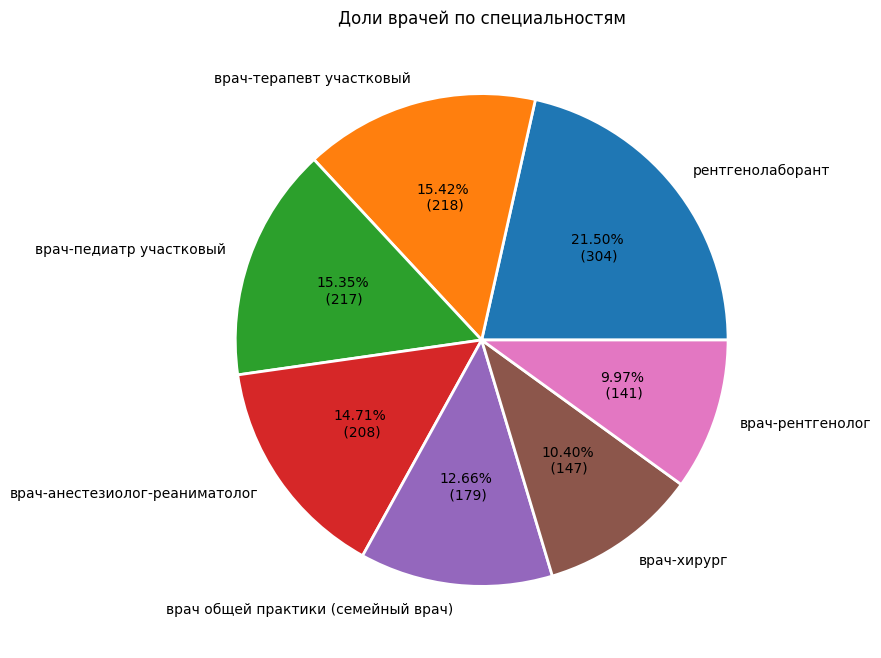

In [ ]:
dd = data['prof'].value_counts()
fig = plt.figure(figsize = (15, 8))
plt.pie(x = dd, labels = dd.index, wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},
        autopct=lambda p : '{:.2f}%'.format(p) + '\n ({:.0f})'.format(p*dd.sum()/100))
plt.title('Доли врачей по специальностям')
plt.show()

Доли врачей различных специальностей - примерно в одинаковые. Больше всех рентгенолаборантов, меньше всего - хирургов

## Распределение врачей по типам МО

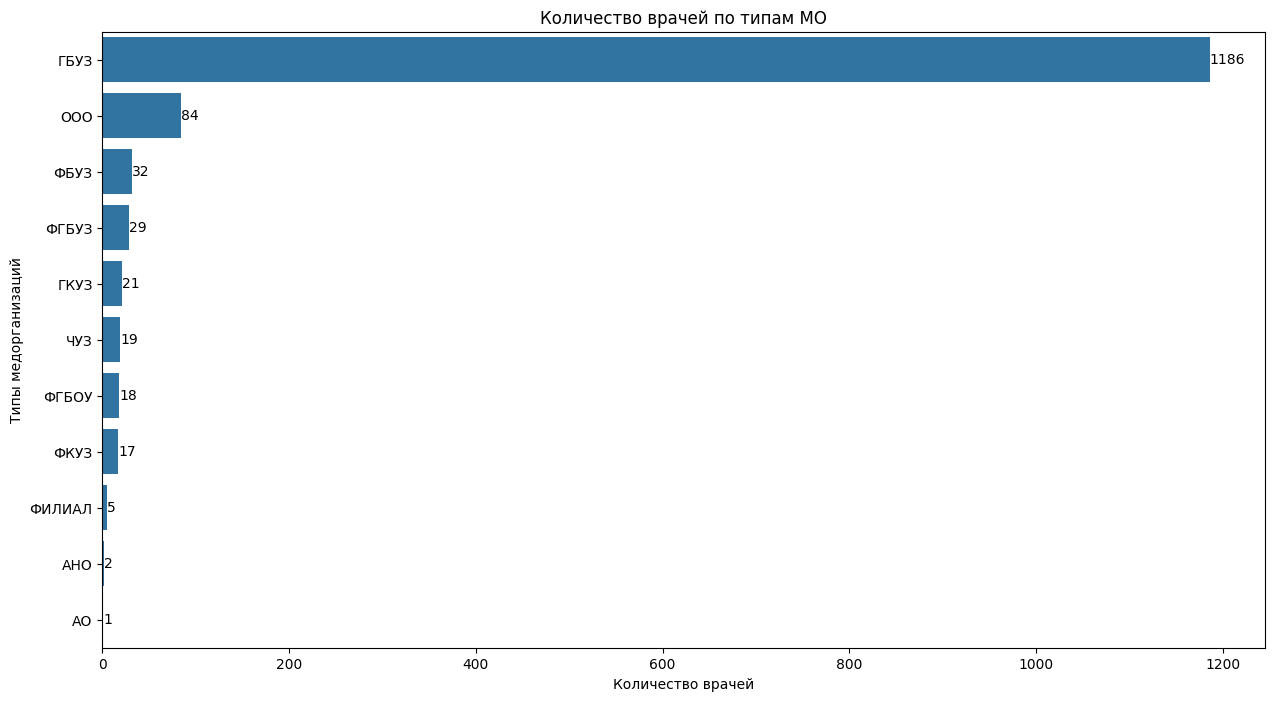

In [ ]:
dd = data['org_type'].value_counts()
fig = plt.figure(figsize = (15, 8))
ax = sns.barplot(x=dd, y=dd.index, color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')
plt.title('Количество врачей по типам МО')
plt.ylabel('Типы медорганизаций')
plt.xlabel('Количество врачей')
plt.show()

Подавляющее больниство врачей работают в госудестванных бюджетных учерддениях здравоохранения

## Распределение врачей по территориям

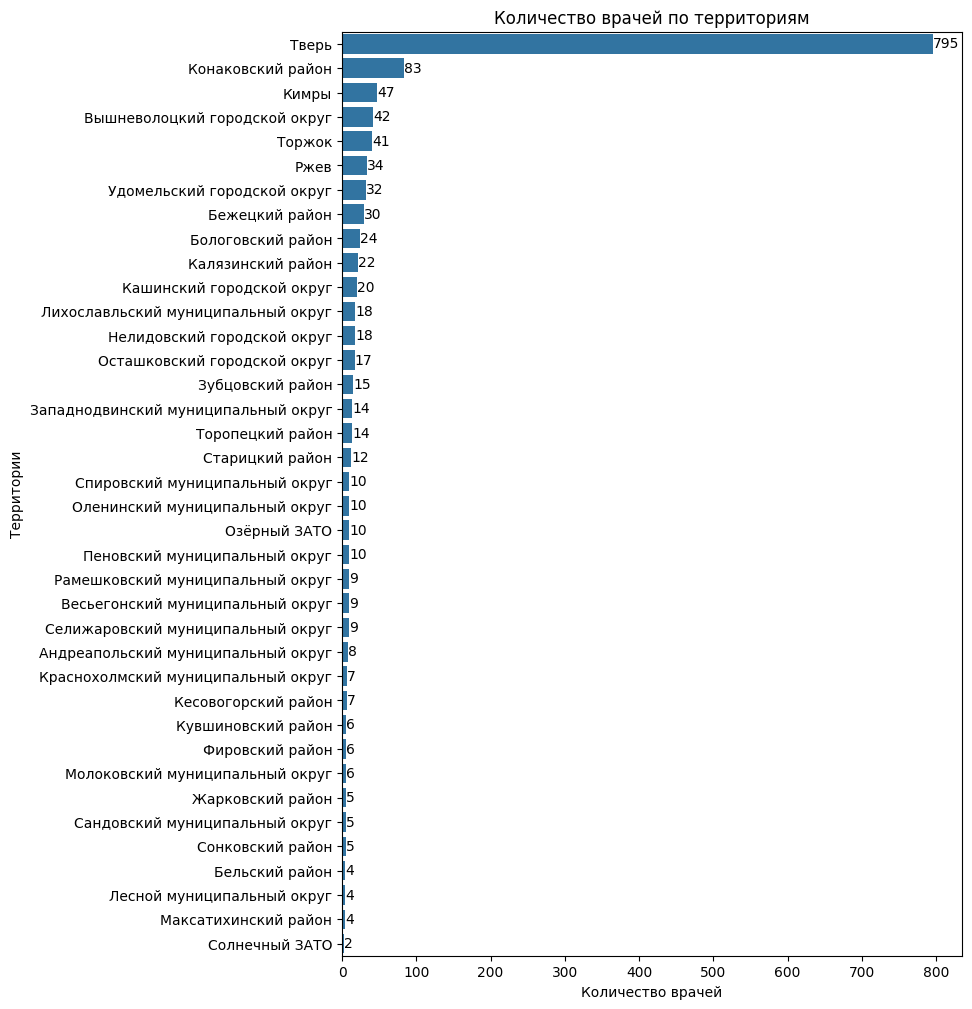

In [ ]:
plt.figure(figsize=(8,12))
dd = data['region'].value_counts()
ax = sns.barplot(x=dd, y=dd.index, color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')

plt.title('Количество врачей по территориям')
plt.ylabel('Территории')
plt.xlabel('Количество врачей')
plt.show()

Закономерно, что в Твери больше всего врачей. В районах области работают единицы врачей.

## Распределение мед огранизаций по территориям

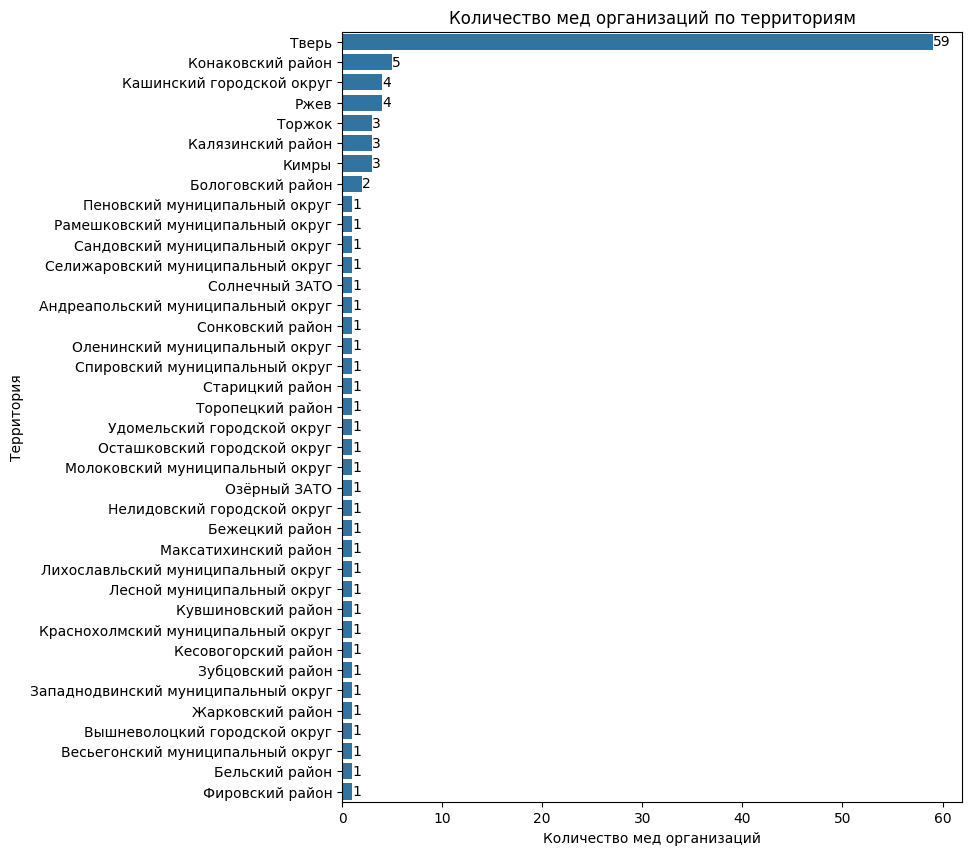

In [ ]:
plt.figure(figsize=(8,10))
dd = data.groupby('region')['org_name'].nunique().sort_values(ascending=False)
ax = sns.barplot(x=dd, y=dd.index, color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')

plt.title('Количество мед организаций по территориям')
plt.ylabel('Территория')
plt.xlabel('Количество мед организаций')
plt.show()

Такая же картина по медицинским организациям. В подавляющем большинстве они сконцентрированы в столице региона.

## ТОП мед организаций по количеству врачей

In [ ]:
print(f"Всего в Тверской области {data['org_name'].nunique()} мед организаций")

Всего в Тверской области 113 мед организаций


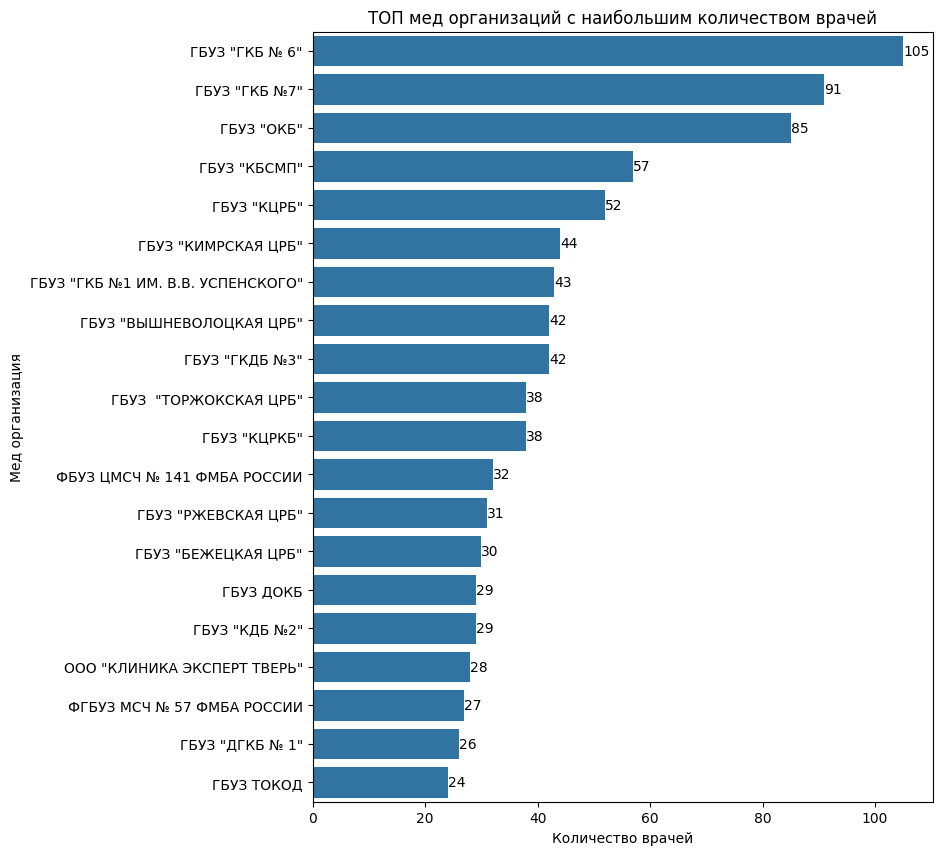

In [ ]:
plt.figure(figsize=(8,10))
dd = data['org_name'].value_counts().head(20)
ax = sns.barplot(x=dd, y=dd.index, color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')

plt.title('ТОП мед организаций с наибольшим количеством врачей')
plt.ylabel('Мед организация')
plt.xlabel('Количество врачей')
plt.show()

Больше всего врачей работает в ГКБ№6, ГКБ№7 и ОКБ

## Тепловая карта количество врачей в координатах территория / профессия

**без Твери, так как столица области всех "забивает"

In [ ]:
dd = data.query('region != "Тверь"').groupby(['region', 'prof'])['id'].count()
dd = dd.reset_index()
dd = dd.pivot_table(index = 'region', columns = 'prof', values = 'id')
dd = dd.fillna(0)
dd.style.apply(background_gradient_alltable, cmap='RdYlGn_r', m=dd.min().min(), M=dd.max().max(), low=0, high=0.1).format(precision=0)

## Возрастное распределение

In [ ]:
age_mean = data['age'].mean()
print(f'Средний возраст врачей - {age_mean:.0f} лет')

Средний возраст врачей - 46 лет


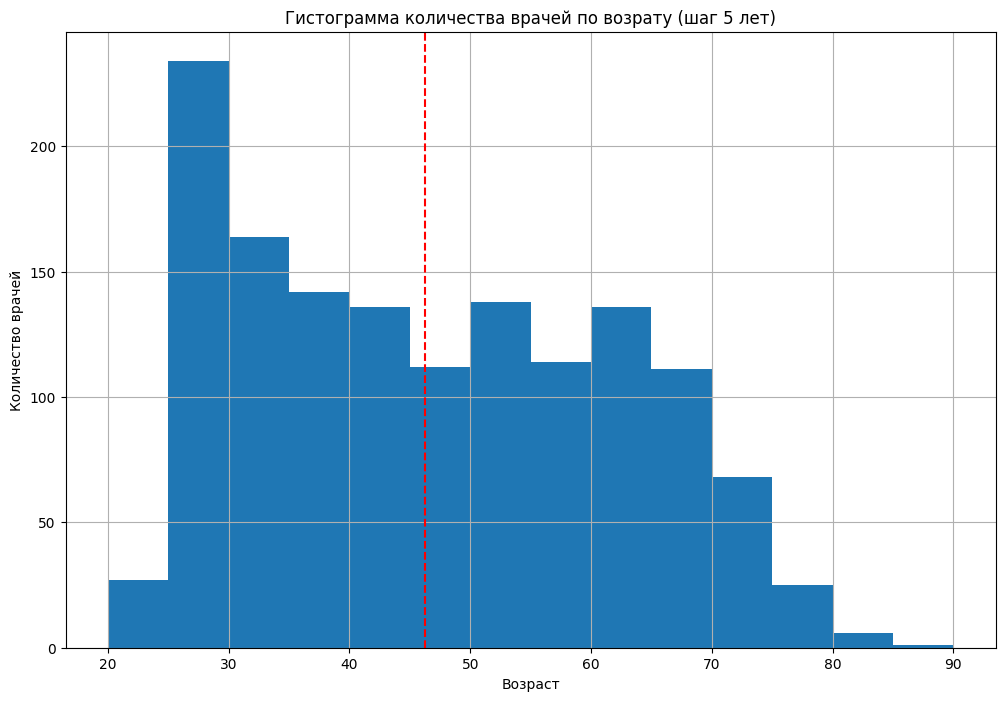

In [ ]:
plt.figure(figsize=(12,8))
data['age'].hist(bins=range(20, 95, 5))
plt.title('Гистограмма количества врачей по возрату (шаг 5 лет)')
plt.ylabel('Количество врачей')
plt.xlabel('Возраст')
plt.axvline(x=data['age'].mean(), color='r', linestyle='--')

plt.show()

Больше всего врачей в когорте 25-30 лет. Врачей в 5-летних когортах между 30 и 65 годами примерно одинаково. После 65 начинается заметное снижение количества врачей.

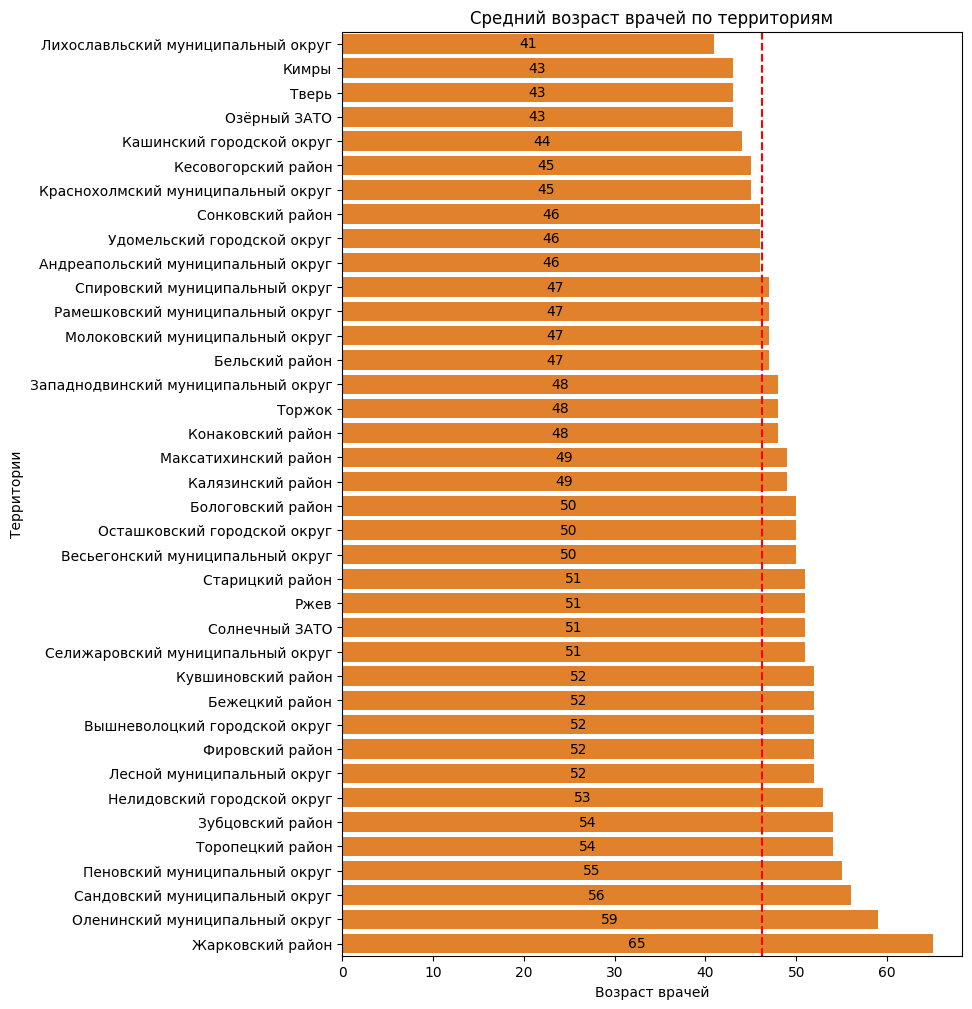

In [ ]:
plt.figure(figsize=(8,12))
dd = data.groupby('region')['age'].mean().astype('int').sort_values()
ax = sns.barplot(x=dd, y=dd.index, color='tab:orange')
ax.bar_label(ax.containers[0], fontsize=10, label_type='center', color='black')

plt.axvline(x=data['age'].mean(), color='r', linestyle='--')
plt.title('Средний возраст врачей по территориям')
plt.ylabel('Территории')
plt.xlabel('Возраст врачей')
plt.show()

В Жарковском районе работают самые возрастные врачи, а в Лихославльском - самые молодые

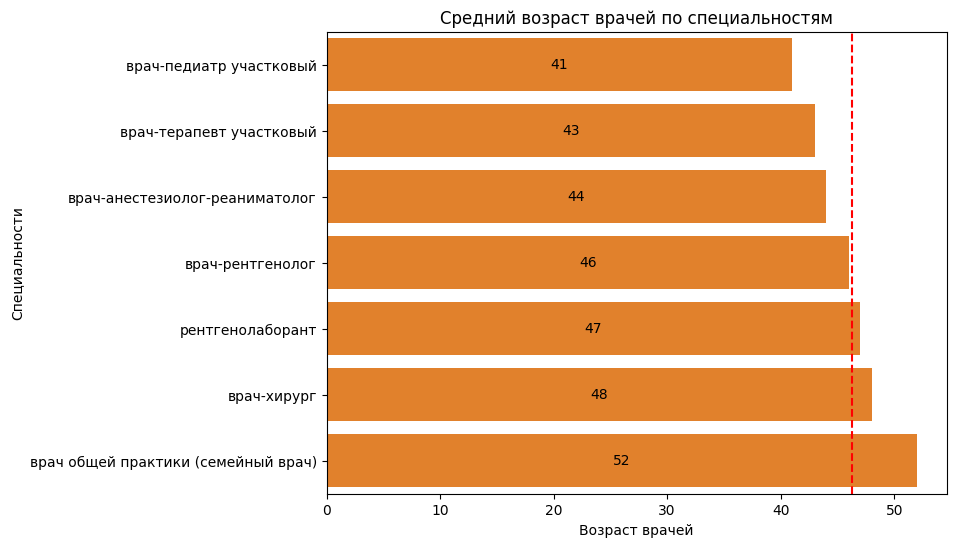

In [ ]:
plt.figure(figsize=(8,6))
dd = data.groupby('prof')['age'].mean().astype('int').sort_values()
ax = sns.barplot(x=dd, y=dd.index, color='tab:orange')
ax.bar_label(ax.containers[0], fontsize=10, label_type='center', color='black')

plt.axvline(x=data['age'].mean(), color='r', linestyle='--')
plt.title('Средний возраст врачей по специальностям')
plt.ylabel('Специальности')
plt.xlabel('Возраст врачей')
plt.show()

Самые возрастные врачи среди семейных врачей, а самые молодые среди участковых педиатров

## Гендерное распределение

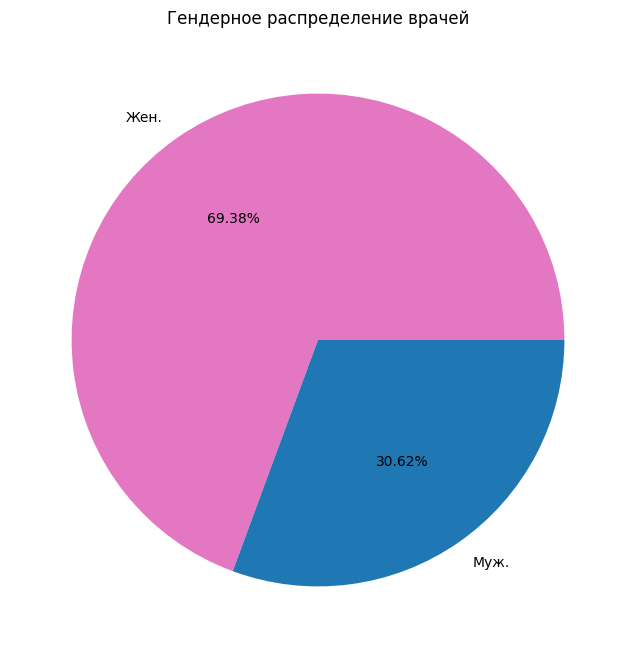

In [ ]:
dd = data.groupby('gender')['gender'].count()
clr = ['tab:pink', 'tab:blue', 'yellow']
plt.figure(figsize=(15,8))
plt.pie(x = dd, labels = dd.index,  autopct=lambda p : '{:.2f}%'.format(p), colors = clr)
plt.title('Гендерное распределение врачей')
plt.show()

Более 2/3 тверских врачей - женщины

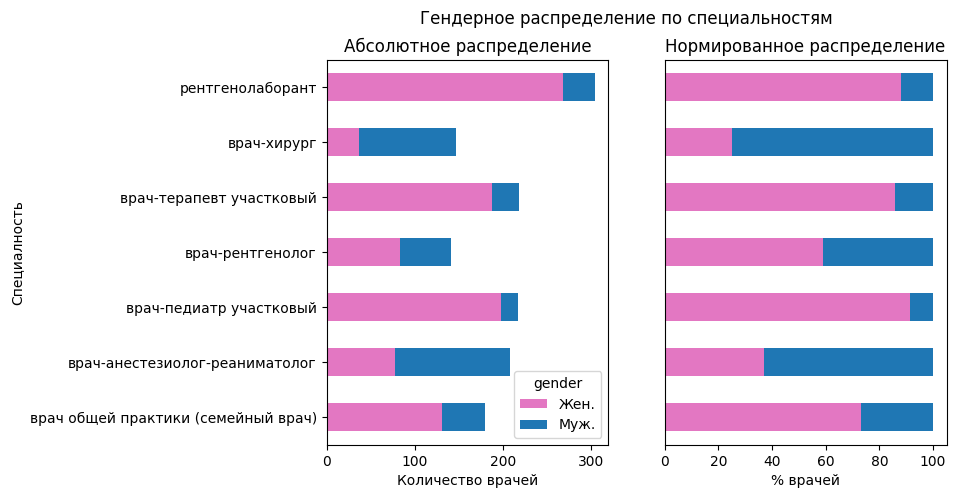

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
clr = ['tab:pink', 'tab:blue', 'yellow']

dd = data.groupby(['prof', 'gender'])['id'].count()
dd = dd.reset_index()
dd = dd.pivot_table(index = 'prof', columns = 'gender', values = 'id')
dd.plot.barh(ax = ax[0],stacked = True, figsize=(8,5), color = clr)

ax[0].set_title('Абсолютное распределение')
ax[0].set_xlabel('Количество врачей')
ax[0].set_ylabel('Специалность')

dd['sum'] = dd.sum(axis=1)
dd = dd.apply(lambda x: 100 * (x / x['sum']), axis=1)
dd = dd.drop(columns = 'sum')

dd.plot.barh(ax = ax[1], stacked = True, figsize=(8,5), color = clr, legend = None)
ax[1].yaxis.set_major_locator(ticker.NullLocator())

ax[1].set_title('Нормированное распределение')
ax[1].set_xlabel('% врачей')
ax[1].set_ylabel('')

plt.suptitle('Гендерное распределение по специальностям')
plt.show()

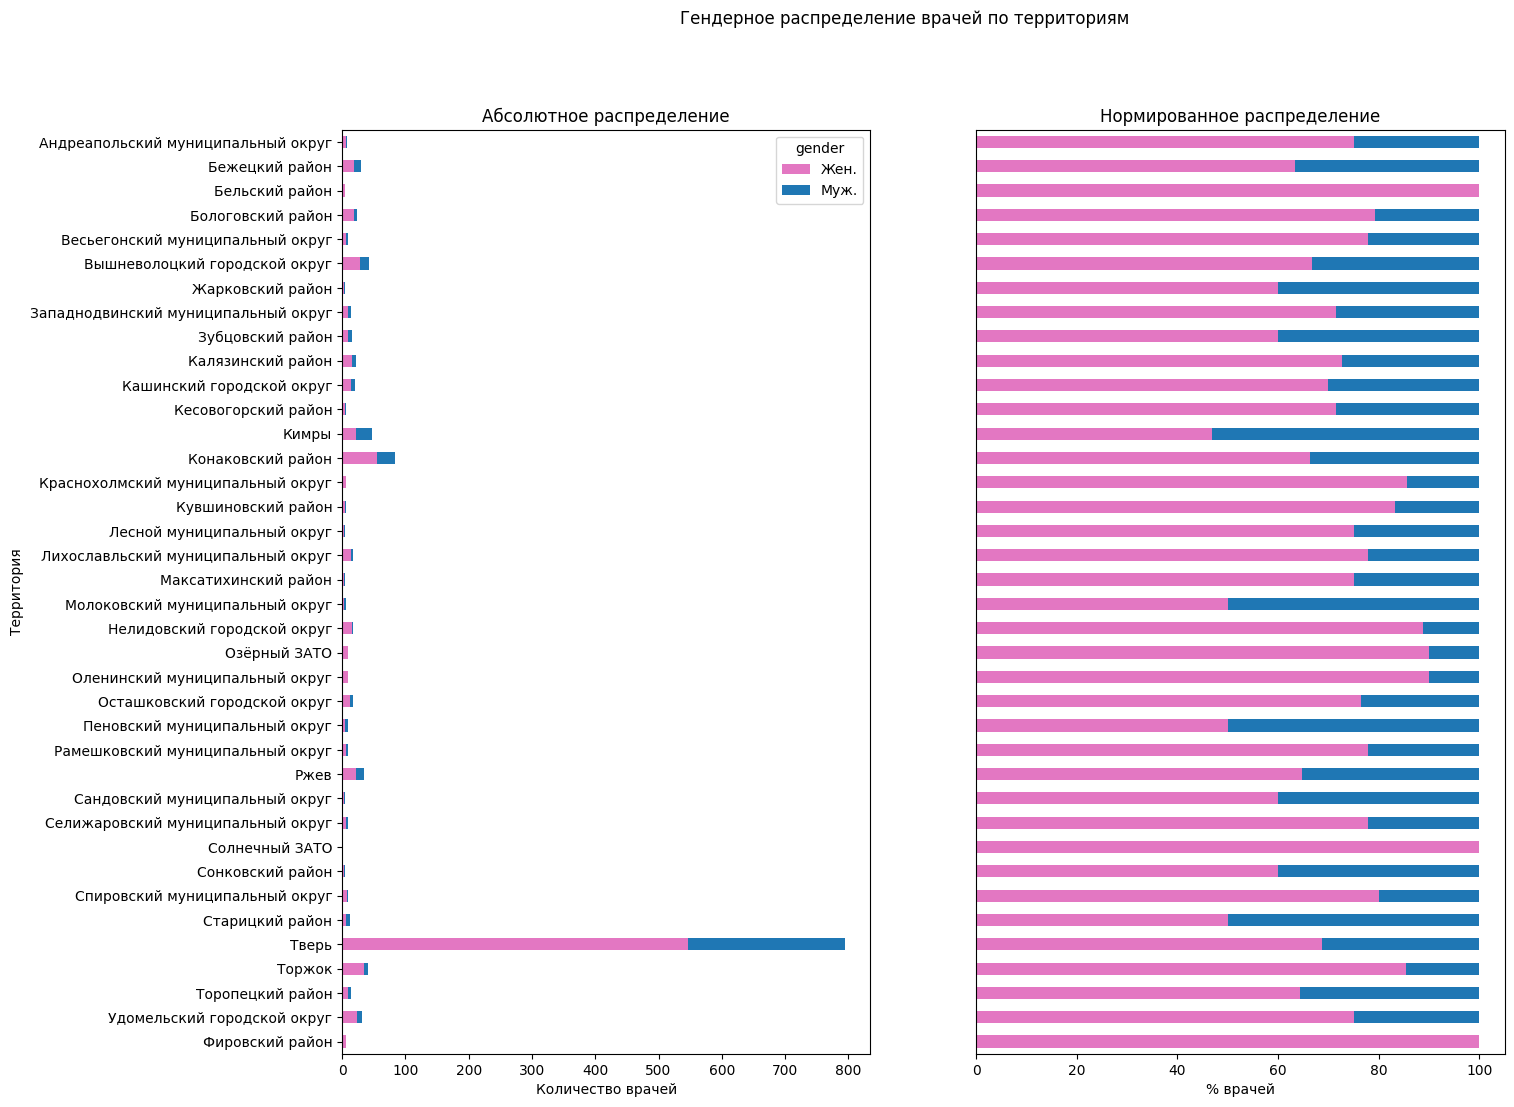

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(15,15))
clr = ['tab:pink', 'tab:blue', 'yellow']


dd = data.groupby(['region', 'gender'])['id'].count().sort_values()
dd = dd.reset_index()
dd = dd.pivot_table(index = 'region', columns = 'gender', values = 'id')
dd = dd.fillna(0)[::-1]
dd.plot.barh(ax = ax[0],stacked = True, figsize=(15,12), color = clr)

ax[0].set_title('Абсолютное распределение')
ax[0].set_xlabel('Количество врачей')
ax[0].set_ylabel('Территория')


dd['sum'] = dd.sum(axis=1)
dd = dd.apply(lambda x: 100 * (x / x['sum']), axis=1)
dd = dd.drop(columns = 'sum')

dd.plot.barh(ax = ax[1], stacked = True, figsize=(15,12), color = clr, legend = None)
ax[1].yaxis.set_major_locator(ticker.NullLocator())

ax[1].set_title('Нормированное распределение')
ax[1].set_xlabel('% врачей')
ax[1].set_ylabel('')

plt.suptitle('Гендерное распределение врачей по территориям')
plt.show()

**Промежуточные итоги**

Построили распределения количества врачей по территориям, медорганизациям, возрастному и гендерному распределению.

Большинство врачей и медорганизаций сосредоточено в Твери. Средний возраст тверских врачей - 46 лет. 2/3 врачей - женщины.

# Ответы на поставленные вопросы

## Обеспеченность врачами

Обеспеченность врачами оценим относительно населения -  по параметру "количество жителей на одного врача".

Для оценки обеспеченности всеми врачами вычислим этот показатель для каждой территории и сравним со средним показателем по всему региону.

Для оценки обеспеченности врачами первичного звена используем рекомендацию Минздрава: "1 должность на 1700 человек взрослого населения в возрасте 18 лет и старше"



In [ ]:
#Формируетм таблицу обеспеченности врачами и возрастов по территориям

dd = data.groupby('region')['id'].count()
docs = pd.merge(tver_pop[['region', 'pop']], dd, how='left', on='region')
docs = docs.rename(columns = {'id' : 'all'})

dd = data.query('prim == 1').groupby('region')['id'].count()
docs = pd.merge(docs, dd, how='left', on='region')
docs = docs.rename(columns = {'id' : 'prim'})

dd = data.groupby('region')['org_name'].nunique()
docs = pd.merge(docs, dd, how='left', on='region')
docs = docs.rename(columns = {'org_name' : 'org_count'})

docs['all_pop'] = docs['pop'] / docs['all']
docs['prim_pop'] = docs['pop'] / docs['prim']

dd = data.query('prim == 1').groupby('region', as_index=False)['age'].mean()
docs = pd.merge(docs, dd, how='left', on='region')
docs = docs.rename(columns = {'age' : 'prim_age'})

dd = data.groupby('region', as_index=False)['age'].mean()
docs = pd.merge(docs, dd, how='left', on='region')
docs = docs.rename(columns = {'age' : 'all_age'})

docs = docs.fillna(0)

docs['all_pop'] = docs['all_pop'].astype('int')
docs['prim_pop'] = docs['prim_pop'].astype('int')
docs['all_age'] = docs['all_age'].astype('int')
docs['prim_age'] = docs['prim_age'].astype('int')

docs

region     pop  all  prim  org_count  \
0    Андреапольский муниципальный округ    9731    8     4          1   
1                        Бежецкий район   30567   30    14          1   
2                        Бельский район    4852    4     3          1   
3                     Бологовский район   30273   24    15          2   
4      Весьегонский муниципальный округ    9486    9     7          1   
5         Вышневолоцкий городской округ   63833   42    11          1   
6                      Жарковский район    3931    5     2          1   
7   Западнодвинский муниципальный округ   11945   14     8          1   
8                      Зубцовский район   14191   15     9          1   
9                     Калязинский район   18994   22    14          3   
10            Кашинский городской округ   22713   20    10          4   
11                  Кесовогорский район    7244    7     5          1   
12                                Кимры   51679   47    17          3   
13                    Конаковский район   67829   83    44          5   
14   Краснохолмский муниципальный округ    8508    7     4          1   
15                   Кувшиновский район   12610    6     4          1   
16           Лесной муниципальный округ    3827    4     3          1   
17   Лихославльский муниципальный округ   24344   18    12          1   
18                 Максатихинский район   13807    4     3          1   
19      Молоковский муниципальный округ    3690    6     4          1   
20          Нелидовский городской округ   22742   18    10          1   
21                         Озёрный ЗАТО   10401   10     8          1   
22       Оленинский муниципальный округ   11371   10     6          1   
23         Осташковский городской округ   20992   17     9          1   
24        Пеновский муниципальный округ    5051   10     5          1   
25     Рамешковский муниципальный округ   14777    9     7          1   
26                                 Ржев   63768   34    13          4   
27       Сандовский муниципальный округ    4788    5     3          1   
28    Селижаровский муниципальный округ    9920    9     6          1   
29                       Солнечный ЗАТО    1797    2     2          1   
30                     Сонковский район    6439    5     3          1   
31       Спировский муниципальный округ    8413   10     7          1   
32                      Старицкий район   20834   12     8          1   
33                                Тверь  472597  795   280         59   
34                               Торжок   58264   41    24          3   
35                     Торопецкий район   16137   14     9          1   
36          Удомельский городской округ   29515   32    16          1   
37                      Фировский район    7887    6     5          1   

    all_pop  prim_pop  prim_age  all_age  
0      1216      2432        41       46  
1      1018      2183        62       52  
2      1213      1617        41       47  
3      1261      2018        52       50  
4      1054      1355        51       50  
5      1519      5803        45       52  
6       786      1965        67       65  
7       853      1493        51       48  
8       946      1576        50       54  
9       863      1356        51       49  
10     1135      2271        44       44  
11     1034      1448        45       45  
12     1099      3039        42       43  
13      817      1541        49       48  
14     1215      2127        40       45  
15     2101      3152        46       52  
16      956      1275        49       52  
17     1352      2028        37       41  
18     3451      4602        49       49  
19      615       922        42       47  
20     1263      2274        51       53  
21     1040      1300        41       43  
22     1137      1895        61       59  
23     1234      2332        48       50  
24      505      1010        56       55  
25     1641      2111        44       47  
26     1875      4905   

In [ ]:
#Проверка сводной таблицы по сумме основных параметров
check.loc[1] = docs.agg({'all' : 'sum', 'prim' : 'sum', 'pop' : 'sum', 'region' : 'count'})
check

all  prim      pop  region
0  1414   614  1199747      38
1  1414   614  1199747      38

Обеспеченность врачами в целом по региону

In [ ]:
pop_doc_all = docs['pop'].sum() / docs['all'].sum()
pop_doc_prim = docs['pop'].sum() / docs['prim'].sum()

print(f"В целом по региону, средний возраст всех врачей {data['age'].mean():.0f}")
print(f"В целом по региону, средний возраст врачей первичного звена {data.query('prim == 1')['age'].mean():.0f}")
print(f"В целом по региону, на одного врача приходится {pop_doc_all:.0f} жителей")
print(f"В целом по региону, на одного врача первичного звена приходится {pop_doc_prim:.0f} жителей")

В целом по региону, средний возраст всех врачей 46
В целом по региону, средний возраст врачей первичного звена 45
В целом по региону, на одного врача приходится 848 жителей
В целом по региону, на одного врача первичного звена приходится 1954 жителей


### Обеспеченность врачами всех специальностей по территориям


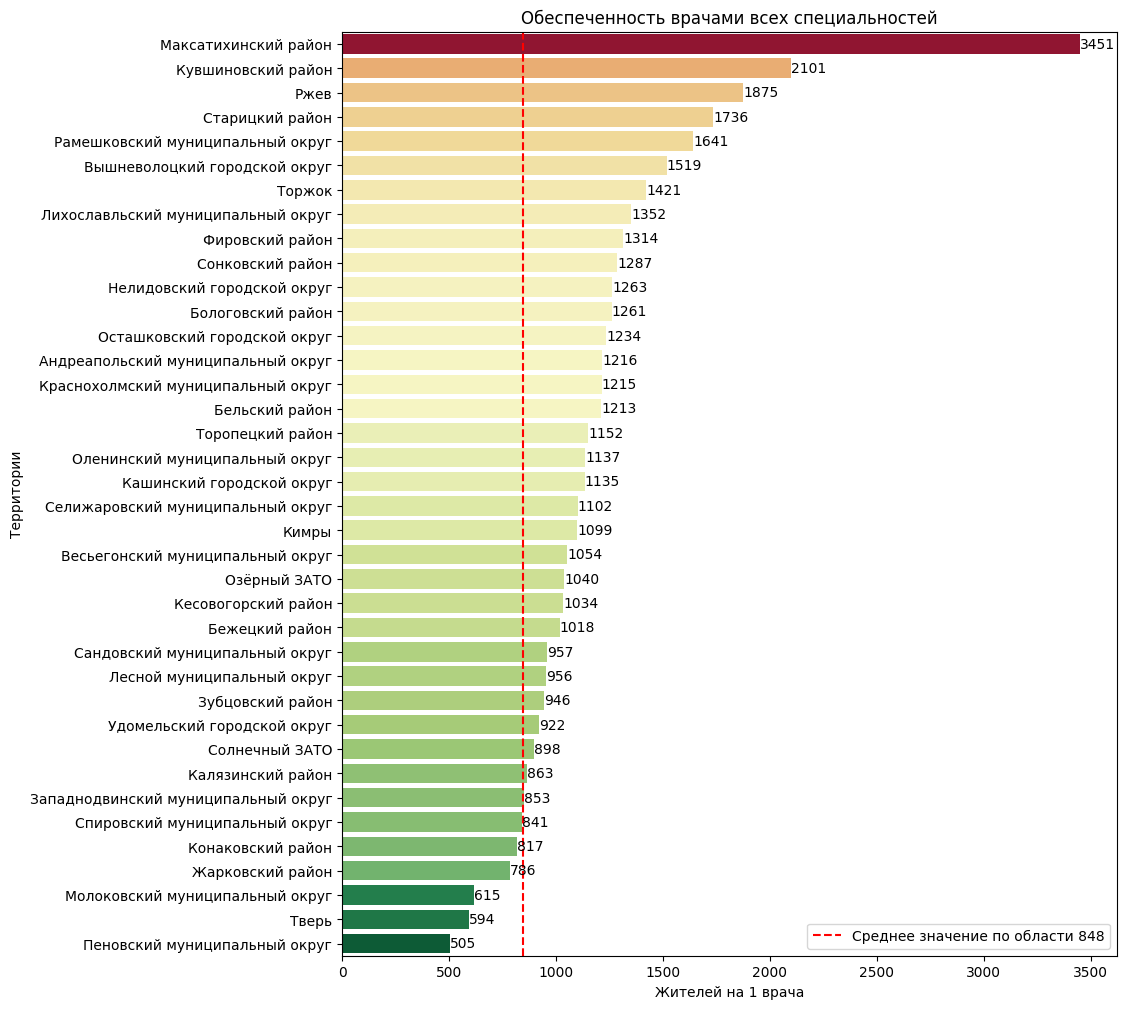

In [ ]:
plt.figure(figsize=(10,12))
dd = docs.sort_values(by = 'all_pop')[::-1]
ax = sns.barplot(x=dd['all_pop'], y=dd['region'], color='tab:orange', palette=gradient_by_value(dd['all_pop']))
for i in range(0, len(dd['all_pop'])): ax.bar_label(ax.containers[i], fontsize=10,label_type='edge', color='black')
plt.axvline(x=pop_doc_all, color='r', linestyle='--', label=f'Среднее значение по области {pop_doc_all:.0f}')

plt.title('Обеспеченность врачами всех специальностей')
plt.ylabel('Территории')
plt.xlabel('Жителей на 1 врача')
plt.legend()
plt.show()

Ниже средней по региону обеспеченность врачами всех специальностей только на 6 территориях - в Твери, Пеновском, Молоковском, Жарковском, Конаковском и Спировском районах.

Больше всего жителей на 1 врача приходится в Максатихинском районе

In [ ]:
map = folium.Map()
colors_pop = gradient_by_value(docs['all_pop'])
for r in range(0, len(docs['region'])):
    reg = docs.loc[r, 'region']
    text = f"В {reg} на 1 врача первичного звена приходится {docs.loc[r, 'all_pop']:.0f} человек"
    folium.GeoJson(tver_pop.loc[r, 'geometry'],
                popup=folium.Popup(text, max_width=300, min_width=300),
               color='black',
               weight=0.2,
               fill=True,
               fill_color=colors_pop[r],
               fill_opacity=0.8).add_to(map)


org = data.groupby('org_name', as_index = False).agg({'id': 'count', 'prim':'sum', 'age': 'mean', 'coord_m' : 'max'})
for i in range(0, len(org)):
    text = f"{org.loc[i, 'org_name']}, всего врачей - {org.loc[i, 'id']}, врачей 1 звена {org.loc[i, 'prim']}"

    folium.Marker(location=org.loc[i, 'coord_m'],
            popup=folium.Popup(text, max_width=300, min_width=300),
            icon=folium.Icon(color='white', icon_color='red', icon='plus'),
            ).add_to(map)

map_title = "Обеспеченность врачами"
title_html = f'<h1 style="position:absolute;z-index:100000;width:100%;text-align:center;">{map_title}</h1>'
map.get_root().html.add_child(folium.Element(title_html))

sw = org['coord_m'].min()
ne = org['coord_m'].max()

map.fit_bounds([sw, ne])
map

### Обеспеченность врачами первичного звена по территориям

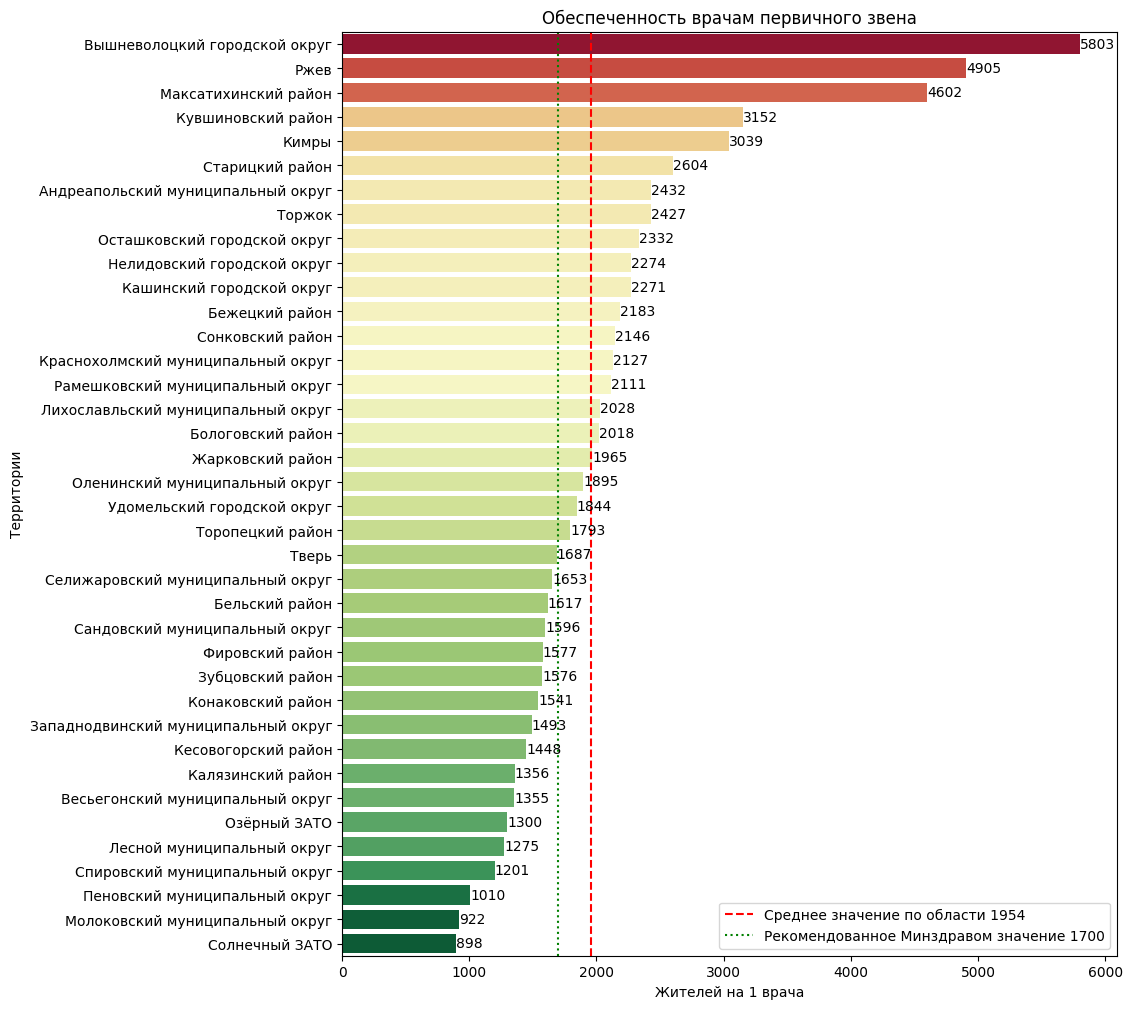

In [ ]:
plt.figure(figsize=(10,12))
dd = docs.sort_values(by = 'prim_pop')[::-1]
ax = sns.barplot(x=dd['prim_pop'], y=dd['region'], palette=gradient_by_value(dd['prim_pop']))
for i in range(0, len(dd['prim_pop'])): ax.bar_label(ax.containers[i], fontsize=10,label_type='edge', color='black')
plt.axvline(x=pop_doc_prim, color='red', linestyle='--', label=f'Среднее значение по области {pop_doc_prim:.0f}' )
plt.axvline(x=1700, color='green', linestyle='dotted', label='Рекомендованное Минздравом значение 1700')
plt.title('Обеспеченность врачам первичного звена')
plt.ylabel('Территории')
plt.xlabel('Жителей на 1 врача')
plt.legend()
plt.show()

Обеспеченность врачами первичного звена выше рекомендованного Минздравом уровня на 17 (из 38) территориях. Примерно по половине территорий региона имеют обеспеченность ниже и выше средней по всей Тверской области

Больше всего жителей на 1 врача первичного звена приходится в Вышневолоцком округе — причем в 3 раза больше рекомендованного. Также высокий показатель в Ржеве и Максатихинском районе.

In [ ]:
map = folium.Map()
colors_pop = gradient_by_value(docs['prim_pop'])
for r in range(0, len(docs['region'])):
    reg = docs.loc[r, 'region']
    text = f"В {reg} на 1 врача первичного звена приходится {docs.loc[r, 'prim_pop']:.0f} человек"
    folium.GeoJson(tver_pop.loc[r, 'geometry'],
                popup=folium.Popup(text, max_width=300, min_width=300),
               color='black',
               weight=0.2,
               fill=True,
               fill_color=colors_pop[r],
               fill_opacity=0.8).add_to(map)


org = data.groupby('org_name', as_index = False).agg({'id': 'count', 'prim':'sum', 'age': 'mean', 'coord_m' : 'max'})
for i in range(0, len(org)):
    text = f"{org.loc[i, 'org_name']}, всего врачей - {org.loc[i, 'id']}, врачей 1 звена {org.loc[i, 'prim']}"

    folium.Marker(location=org.loc[i, 'coord_m'],
            popup=folium.Popup(text, max_width=300, min_width=300),
            icon=folium.Icon(color='white', icon_color='red', icon='plus'),
            ).add_to(map)

map_title = "Обеспеченность врачами первичного звена"
title_html = f'<h1 style="position:absolute;z-index:100000;width:100%;text-align:center;">{map_title}</h1>'
map.get_root().html.add_child(folium.Element(title_html))

sw = org['coord_m'].min()
ne = org['coord_m'].max()
map.fit_bounds([sw, ne])
map

## Обеспеченность врачами ближних / дальних районов

Для оценки обеспеченности врачами в ближних и дальних от Твери районах разобъем их на группы:
- Тверь, включая Калининский район
- Ближние районы - районы, которые граничат с Калининским районом
- Средние районы - районы, которые граничат с ближними районами
- Дальние районы - все остальные районы

После чего также оценим обеспеченность врачей в группах районов по показателю «Количество жителей на 1 врача».

In [ ]:
#Набиваем группы вручную, глядя на карту
near_reg = dict()
near_reg[0] = ['Тверь']
near_reg[1] = ['Конаковский район', 'Старицкий район', 'Торжок',
               'Лихославльский муниципальный округ', 'Рамешковский муниципальный округ', 'Кимры']
near_reg[2] = ['Зубцовский район', 'Ржев', 'Селижаровский муниципальный округ', 'Кувшиновский район',
            'Вышневолоцкий городской округ', 'Спировский муниципальный округ', 'Максатихинский район',
            'Бежецкий район', 'Кашинский городской округ', 'Калязинский район']

In [ ]:
#Формируем таблицу групп ближних/дальних районов
near_far = pd.DataFrame(columns = ('near', 'id', 'prim', 'age', 'pop', 'regs'))
for i in range(0, len(near_reg)):
  near_r = near_reg[i]
  near_far.loc[i] = data.query('region in @near_r').agg({'id': 'count', 'prim': 'sum', 'age': 'mean'})
  near_far.loc[i, 'regs'] = ', '.join(near_r)
  near_far.loc[i, 'pop'] = docs.query('region in @near_r')['pop'].sum()
  if i == 0: near_far.loc[i, 'near'] = 'Тверь'
  if i == 1: near_far.loc[i, 'near'] = 'Ближние районы'
  if i == 2: near_far.loc[i, 'near'] = 'Средние районы'

ff = near_reg[0] + near_reg[1] + near_reg[2]
near_far.loc[3] = data.query('region not in @ff').agg({'id': 'count', 'prim': 'sum', 'age': 'mean'})
near_far.loc[3, 'pop'] = docs.query('region not in @ff')['pop'].sum()
near_far.loc[3, 'regs'] = ', '.join(docs.query('region not in @ff')['region'].tolist())
near_far.loc[3, 'near'] = 'Дальние районы'

near_far = near_far.rename(columns={'id' : 'all'})
near_far['all_pop'] = near_far['pop'] / near_far['all']
near_far['prim_pop'] = near_far['pop'] / near_far['prim']

near_far['all'] = near_far['all'].astype('int')
near_far['prim'] = near_far['prim'].astype('int')
near_far['age'] = near_far['age'].astype('int')
near_far['pop'] = near_far['pop'].astype('int')
near_far['all_pop'] = near_far['all_pop'].astype('int')
near_far['prim_pop'] = near_far['prim_pop'].astype('int')


near_far

near  all  prim  age     pop  \
0           Тверь  795   280   43  472597   
1  Ближние районы  210   112   46  237727   
2  Средние районы  192    91   50  258816   
3  Дальние районы  217   131   50  230607   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             regs  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Тверь   
1                                                                                                                                                                                                                                                                                                                                                                                                                                         Конаковский район, Старицкий район, Торжок, Лихославльский муниципальный округ, Рамешковский муниципальный округ, Кимры   
2                                                                                                                                                                                                                                                                                                                                Зубцовский район, Ржев, Селижаровский муниципальный округ, Кувшиновский район, Вышневолоцкий городской округ, Спировский муниципальный округ, Максатихинский район, Бежецкий район, Кашинский городской округ, Калязинский район   
3  Андреапольский муниципальный округ, Бельский район, Бологовский район, Весьегонский муниципальный округ, Жарковский район, Западнодвинский муниципальный округ, Кесовогорский район, Краснохолмский муниципальный округ, Лесной муниципальный округ, Молоковский муниципальный округ, Нелидовский городской округ, Озёрный ЗАТО, Оленинский муниципальный округ, Осташковский городской округ, Пеновский муниципальный округ, Сандовский муниципальный округ, Солнечный ЗАТО, Сонковский район, Торопецкий район, Удомельский городской округ, Фировский район   

   all_pop  prim_pop  
0      594      1687  
1     1132      2122  
2     1348      2844  
3     1062      1760

In [ ]:
#Проверка по сумме параметров
check.loc[2] = near_far.agg({'all' : 'sum', 'prim' : 'sum', 'pop' : 'sum'})
check.loc[2, 'region'] = len(', '.join(near_far['regs']).split(', '))
check

all   prim        pop  region
0  1414.0  614.0  1199747.0    38.0
1  1414.0  614.0  1199747.0    38.0
2  1414.0  614.0  1199747.0    38.0

### Обеспеченность врачами всех специальностей

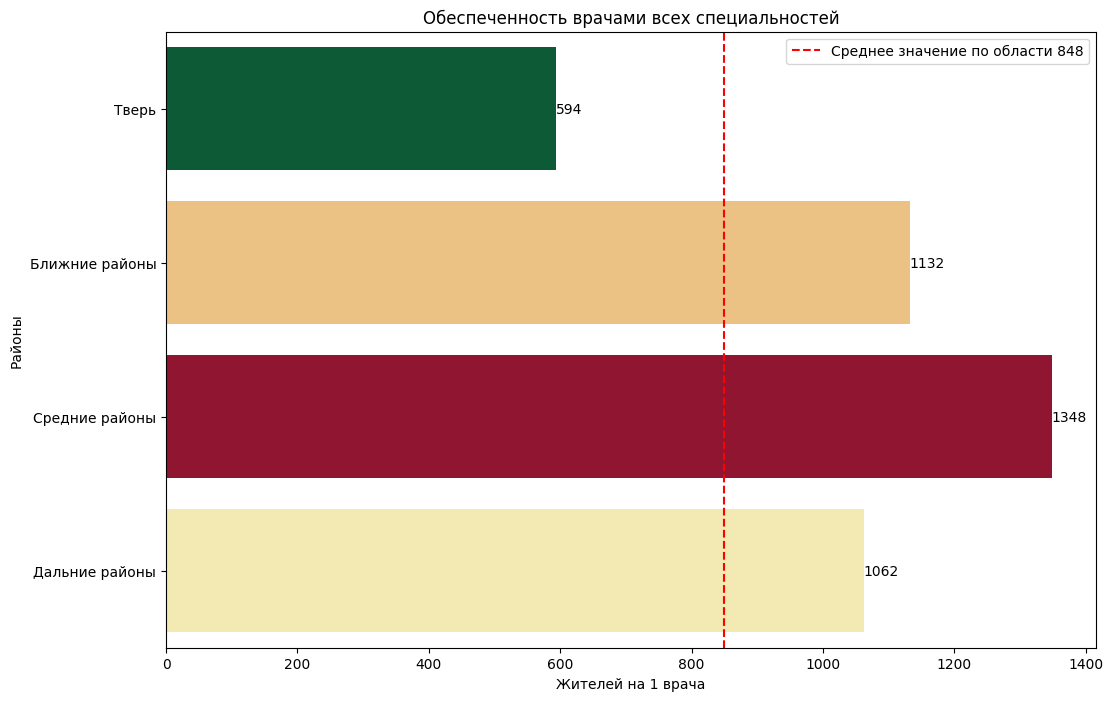

In [ ]:
plt.figure(figsize=(12,8))
dd = near_far
ax = sns.barplot(x=dd['all_pop'], y=dd['near'], color='tab:orange', palette=gradient_by_value(dd['all_pop']))
for i in range(0, len(dd['all_pop'])): ax.bar_label(ax.containers[i], fontsize=10,label_type='edge', color='black')
plt.axvline(x=pop_doc_all, color='r', linestyle='--', label=f'Среднее значение по области {pop_doc_all:.0f}')

plt.title('Обеспеченность врачами всех специальностей')
plt.ylabel('Районы')
plt.xlabel('Жителей на 1 врача')
plt.legend()
plt.show()

У врачей всех специальностей наибольшая нагрузка в средних по удаленности от столицы области районах

In [ ]:
map = folium.Map()
colors_pop = gradient_by_value(near_far['all_pop'])
for nr in range(0, len(near_far['near'])):
  raions = near_far.loc[nr, 'regs'].split(', ')
  text = f"В {near_far.loc[nr, 'near']} на 1 врача приходится {near_far.loc[nr, 'all_pop']:.0f} человек"

  for r in range(0, len(raions)):
    reg = raions[r]
    folium.GeoJson(tver_pop.loc[tver_pop[tver_pop['region'] == reg].index[0], 'geometry'],
                popup=folium.Popup(text, max_width=300, min_width=300),
               color='black',
               weight=0.2,
               fill=True,
               fill_color=colors_pop[nr],
               fill_opacity=0.8).add_to(map)

org = data.groupby('org_name', as_index = False).agg({'id': 'count', 'prim':'sum', 'age': 'mean', 'coord_m' : 'max'})
for i in range(0, len(org)):
    text = f"{org.loc[i, 'org_name']}, всего врачей - {org.loc[i, 'id']}, врачей 1 звена {org.loc[i, 'prim']}"

    folium.Marker(location=org.loc[i, 'coord_m'],
            popup=folium.Popup(text, max_width=300, min_width=300),
            icon=folium.Icon(color='white', icon_color='red', icon='plus'),
            ).add_to(map)


map_title = "Обеспеченность врачами первичного звена в ближних / дальних районах"
title_html = f'<h1 style="position:absolute;z-index:100000;width:100%;text-align:center;">{map_title}</h1>'
map.get_root().html.add_child(folium.Element(title_html))

sw = org['coord_m'].min()
ne = org['coord_m'].max()
map.fit_bounds([sw, ne])
map

### Обеспеченность врачами первичного звена

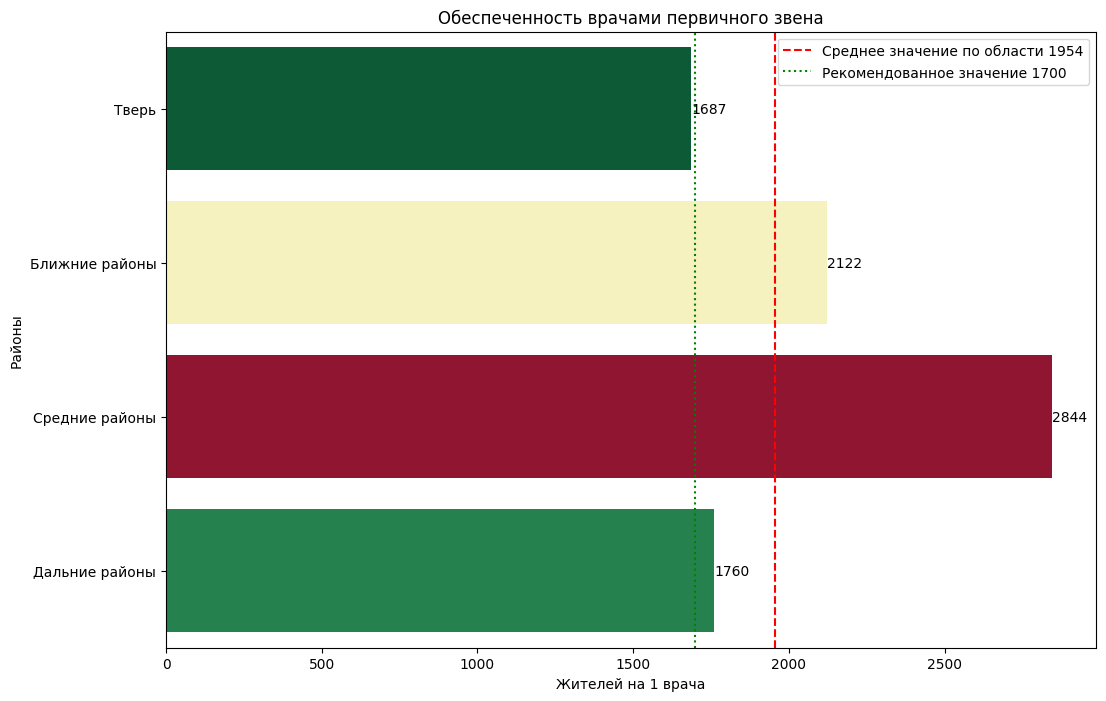

In [ ]:
plt.figure(figsize=(12,8))

dd = near_far
ax = sns.barplot(x=dd['prim_pop'], y=dd['near'], color='tab:orange', palette=gradient_by_value(dd['prim_pop']))
for i in range(0, len(dd['prim_pop'])): ax.bar_label(ax.containers[i], fontsize=10,label_type='edge', color='black')
plt.axvline(x=pop_doc_prim, color='r', linestyle='--', label=f'Среднее значение по области {pop_doc_prim:.0f}')
plt.axvline(x=1700, color='g', linestyle='dotted', label=f'Рекомендованное значение 1700')

plt.title('Обеспеченность врачами первичного звена')
plt.ylabel('Районы')
plt.xlabel('Жителей на 1 врача')
plt.legend()
plt.show()

Такая же картина по врачам первичного звена - средние и ближние районы имеют наибольший показатель "количество жителей на 1 врача". В Твери и дальних районах обеспеченность врачами первичного звена лучше.

In [ ]:
map = folium.Map()
colors_pop = gradient_by_value(near_far['prim_pop'])
for nr in range(0, len(near_far['near'])):
  raions = near_far.loc[nr, 'regs'].split(', ')
  text = f"В {near_far.loc[nr, 'near']} на 1 врача первичного звена приходится {near_far.loc[nr, 'prim_pop']:.0f} человек"

  for r in range(0, len(raions)):
    reg = raions[r]
    folium.GeoJson(tver_pop.loc[tver_pop[tver_pop['region'] == reg].index[0], 'geometry'],
                popup=folium.Popup(text, max_width=300, min_width=300),
               color='black',
               weight=0.2,
               fill=True,
               fill_color=colors_pop[nr],
               fill_opacity=0.8).add_to(map)

org = data.groupby('org_name', as_index = False).agg({'id': 'count', 'prim':'sum', 'age': 'mean', 'coord_m' : 'max'})
for i in range(0, len(org)):
    text = f"{org.loc[i, 'org_name']}, всего врачей - {org.loc[i, 'id']}, врачей 1 звена {org.loc[i, 'prim']}"

    folium.Marker(location=org.loc[i, 'coord_m'],
            popup=folium.Popup(text, max_width=300, min_width=300),
            icon=folium.Icon(color='white', icon_color='red', icon='plus'),
            ).add_to(map)


map_title = "Обеспеченность врачами первичного звена в ближних / дальних районах"
title_html = f'<h1 style="position:absolute;z-index:100000;width:100%;text-align:center;">{map_title}</h1>'
map.get_root().html.add_child(folium.Element(title_html))

sw = org['coord_m'].min()
ne = org['coord_m'].max()
map.fit_bounds([sw, ne])
map

**Ответ на вопрос: Верно ли, что наибольший «кадровый голод» первичного звена ощущается в районах, расположенных ближе к городу и наименьший – в отдаленных районах?**

Обеспеченность врачами первичного звена больше всего в Твери - 1687 жителей на 1 врача - почти на уровне рекомендаций Минздрава. В дальних районах области обеспеченность врачами первичного звена - 1760 - чуть выше рекомендаций. В ближних районах от Твери уже ощущается "кадровый голод" - на одного врача первичного звена там приходится уже 2122 жителей. Хуже всего с обеспеченностью кадрами в средних по удаленности районах - там показатель достигает 2844 жителей на одного врача первичного звена.

## Возраст врачей по территориям

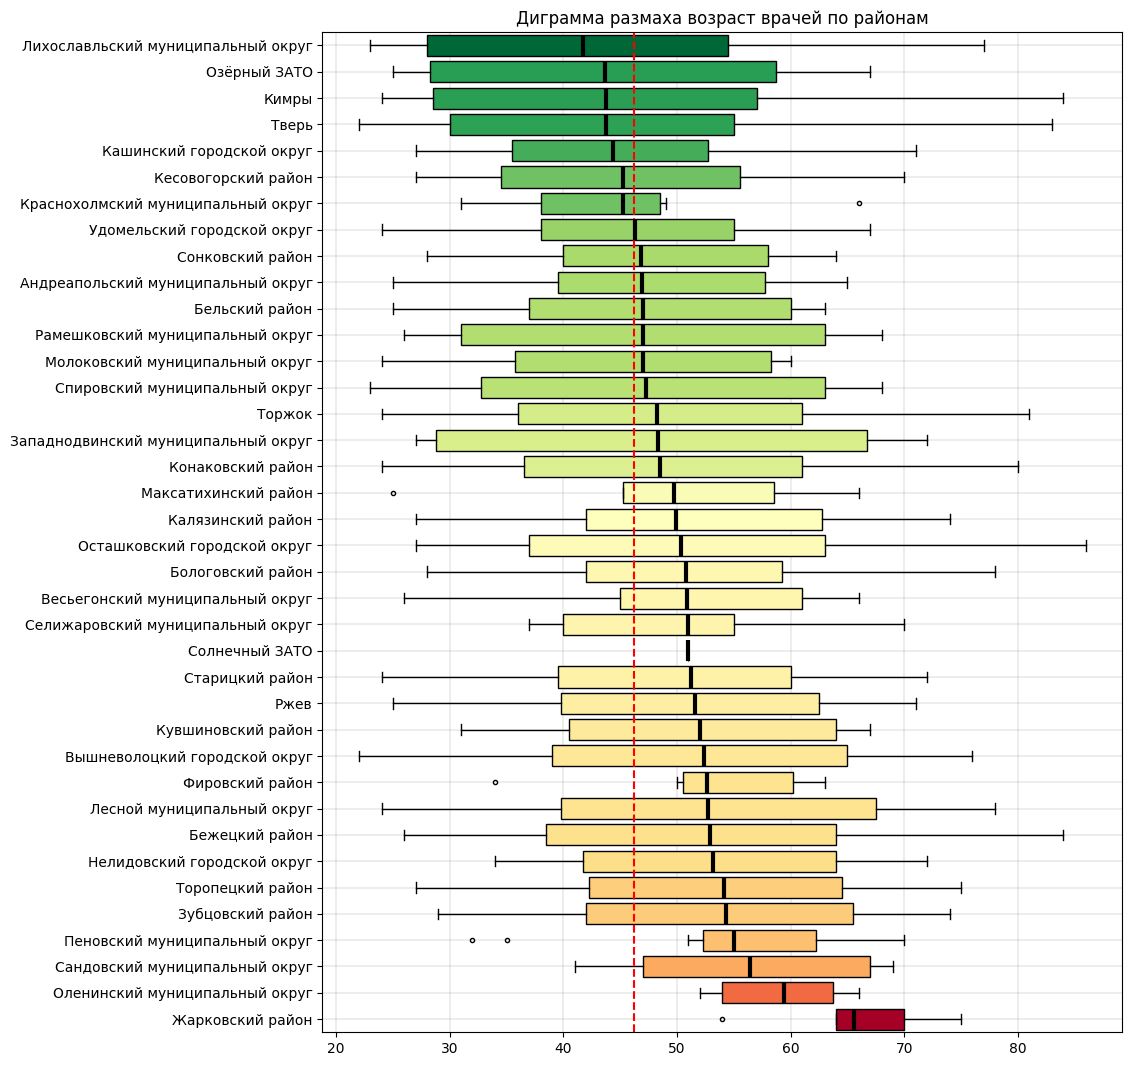

In [ ]:
dd = data.groupby('region', as_index=False)['age'].mean().sort_values(by='age', ascending=False)

c = gradient_by_value(dd['age'])
i = 0

fig = plt.figure(figsize = (8, 10))
ax = fig.add_axes([0, 0, 1, 1])
for reg in dd['region']:
    ax.boxplot(data.query('region == @reg')['age'], vert= False, positions=[i], tick_labels = [reg], widths = 0.8 , sym = '.',\
               showmeans = True, meanline = True, patch_artist=True, boxprops=dict(facecolor=c[i]), \
               medianprops=dict(color='black', linewidth=0), meanprops=dict(color='black', linewidth=3, linestyle='-')
              )
    i +=1
plt.axvline(x=age_mean, color='r', linestyle='--')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.title('Диграмма размаха возраст врачей по районам')
plt.show()

In [ ]:
map = folium.Map()
colors_pop = gradient_by_value(docs['all_age'])
for r in range(0, len(docs['region'])):
    reg = docs.loc[r, 'region']
    text = f"Средний возраст врачей в {reg} - {docs.loc[r, 'all_age']:.0f}"
    folium.GeoJson(tver_pop.loc[r, 'geometry'],
                popup=folium.Popup(text, max_width=300, min_width=300),
               color='black',
               weight=0.2,
               fill=True,
               fill_color=colors_pop[r],
               fill_opacity=0.8).add_to(map)

org = data.groupby('org_name', as_index = False).agg({'id': 'count', 'prim':'sum', 'age': 'mean', 'coord_m' : 'max'})
for i in range(0, len(org)):
    text = f"{org.loc[i, 'org_name']}, средний возраст {org.loc[i, 'age']:.0f}"

    folium.Marker(location=org.loc[i, 'coord_m'],
            popup=folium.Popup(text, max_width=300, min_width=300),
            icon=folium.Icon(color='white', icon_color='red', icon='plus'),
            ).add_to(map)

map_title = "Средний возраст врачей по территориям"
title_html = f'<h1 style="position:absolute;z-index:100000;width:100%;text-align:center;">{map_title}</h1>'
map.get_root().html.add_child(folium.Element(title_html))

sw = org['coord_m'].min()
ne = org['coord_m'].max()
map.fit_bounds([sw, ne])
map

**Ответ на вопрос: В каких районах самые молодые, а в каких - самые старые врачи?**

В Жарковском районе работают самые возрастные врачи, а в Лихославльском - самые молодые.

Всего на 8 территориях средний возраст врачей ниже среднего по области в целом  

## Доля врачей пенсионного возраста

Хотя врачи имеют право на досрочный выход на пенсию, таких данных в исходном датасете нет. Оценим долю врачей пенсионного возраста, учитывая, что в 2024 году пенсионный возраст в России для женщин составлял 58 лет, а для мужчин — 63 года

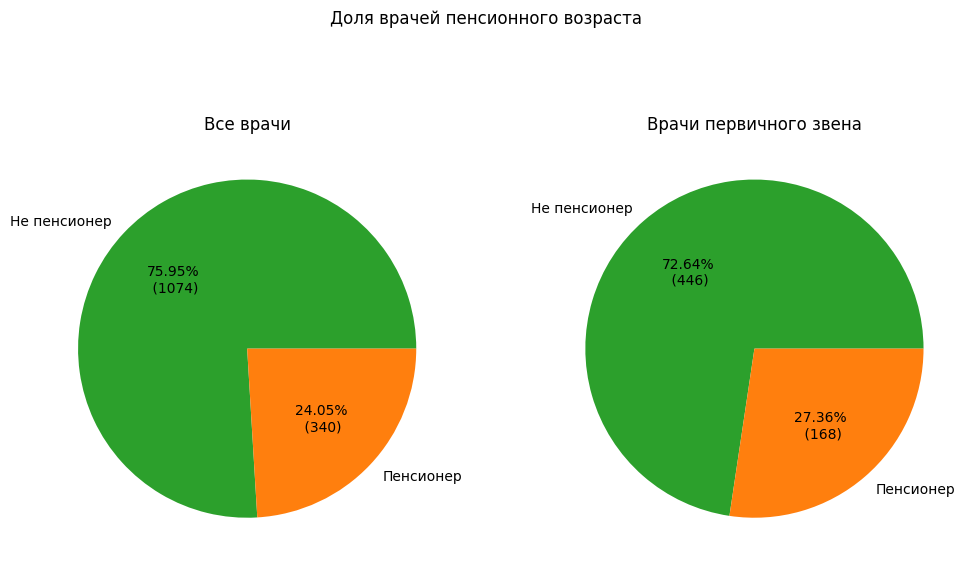

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(12,7))

clr = ['tab:green', 'tab:orange', 'yellow']
dd = data['pens'].value_counts()
ax[0].pie(x = dd, labels = dd.index, colors = clr,
        autopct=lambda p : '{:.2f}%'.format(p) + '\n ({:.0f})'.format(p*dd.sum()/100))
ax[0].set_title('Все врачи')

dd = data.query('prim == 1')['pens'].value_counts()
ax[1].pie(x = dd, labels = dd.index, colors = clr,
        autopct=lambda p : '{:.2f}%'.format(p) + '\n ({:.0f})'.format(p*dd.sum()/100))

ax[1].set_title('Врачи первичного звена')
plt.suptitle('Доля врачей пенсионного возраста')
plt.show()

**Ответ на вопрос: Верно ли, что большинство медицинских работников в Тверской области пенсионного возраста?**

Неверно. 3/4 медработников в Тверской области еще не достигли пенсионного возраста. Однако среди врачей первичного звена врачей пенсионного возраста более 27%.

## Гендерное распределение среди врачей в возрасте 60+ лет

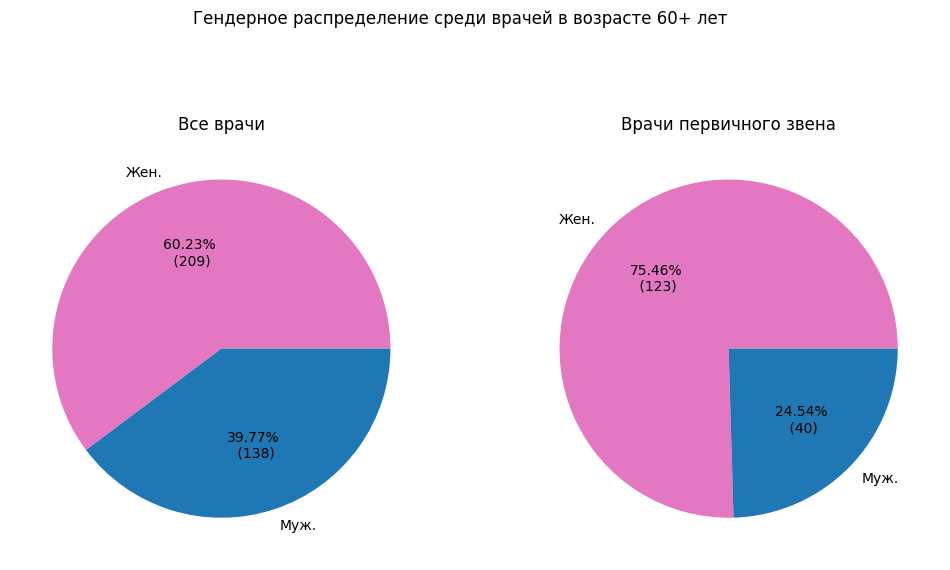

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(12,7))

clr = ['tab:pink', 'tab:blue', 'yellow']
dd = data.query('age >=60')['gender'].value_counts()
ax[0].pie(x = dd, labels = dd.index, colors = clr,
        autopct=lambda p : '{:.2f}%'.format(p) + '\n ({:.0f})'.format(p*dd.sum()/100))
ax[0].set_title('Все врачи')

dd = data.query('age >=60 & prim == 1')['gender'].value_counts()
ax[1].pie(x = dd, labels = dd.index, colors = clr,
        autopct=lambda p : '{:.2f}%'.format(p) + '\n ({:.0f})'.format(p*dd.sum()/100))

ax[1].set_title('Врачи первичного звена')
plt.suptitle('Гендерное распределение среди врачей в возрасте 60+ лет')
plt.show()

**Ответ на вопрос: Верно ли, что женщин в возрасте 60+ работает меньше, чем мужчин в возрасте 60+?**

Верно, среди медработников в возрасте 60+ больше женщин. Причем среди врачей первичного звена женщин - 75%.

## Гендерное распределение среди врачей в возрасте 30-50 лет

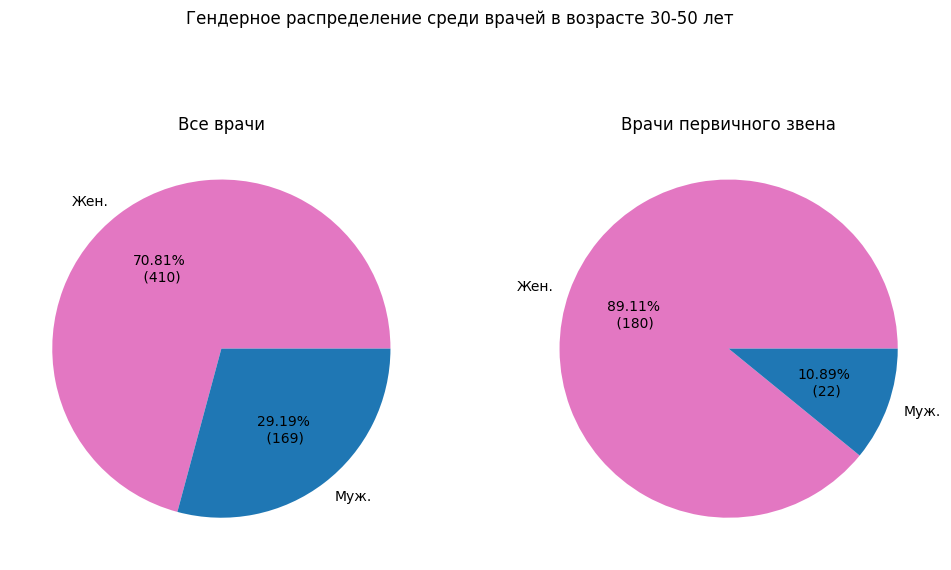

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(12,7))

clr = ['tab:pink', 'tab:blue', 'yellow']
dd = data.query('30 <= age <=50')['gender'].value_counts()
ax[0].pie(x = dd, labels = dd.index, colors = clr,
        autopct=lambda p : '{:.2f}%'.format(p) + '\n ({:.0f})'.format(p*dd.sum()/100))
ax[0].set_title('Все врачи')

dd = data.query('30 <= age <=50 & prim == 1')['gender'].value_counts()
ax[1].pie(x = dd, labels = dd.index, colors = clr,
        autopct=lambda p : '{:.2f}%'.format(p) + '\n ({:.0f})'.format(p*dd.sum()/100))

ax[1].set_title('Врачи первичного звена')
plt.suptitle('Гендерное распределение среди врачей в возрасте 30-50 лет')
plt.show()

**Ответ на вопрос: Верно ли, что женщин в возрасте 30-50 лет работает больше, чем мужчин этого же возраста?**

Верно, среди медработников в возрасте 30-50 больше женщин. Причем среди врачей первичного звена - почти 90%.

## Доля врачей до 35 лет

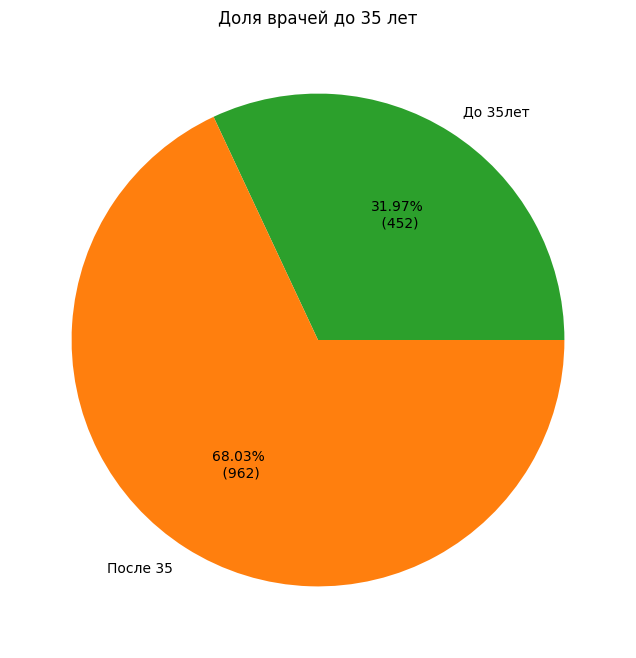

In [ ]:
spec35 = data.query('age <= 35')['id'].count()

clr = ['tab:green', 'tab:orange', 'yellow']
plt.figure(figsize=(15,8))
plt.pie(x = [spec35, datalen - spec35], colors = clr, labels = ['До 35лет', 'После 35'],
        autopct=lambda p : '{:.2f}%'.format(p)+'\n ({:.0f})'.format(p*datalen/100))
plt.title('Доля врачей до 35 лет')
plt.show()

**Ответ на вопрос: Верно ли, что молодые специалисты (до 35 лет) уезжают в другие регионы и не остаются работать ни в Твери, ни в районах Тверской области?**

Не верно, в мед организациях Тверской области 1/3 врачей - молодые специалисты в возрасте до 35 лет.

## Недавние выпускники среди врачей первичного звена

Отделить выпускников ТГМУ от выпускников других медицинских образовательных учреждений по предоставленным данным - не представляется возможным. Также нельзя никак определить в каком году они устроились на работу.

Оценим общее количество недавних выпускников, какое бы учебное заведение они не оканчивали

In [ ]:
spec27_t = data.query('age <= 27 & prim == 1 & region == "Тверь"')['id'].count()
spec27 = data.query('age <= 27 & prim == 1 & region != "Тверь"')['id'].count()
print(f"Всего недавних выпускников среди врачей первичного звена {spec27_t + spec27}")
print(f"Из них {spec27_t} работают в Твери и {spec27} в области")


Всего недавних выпускников среди врачей первичного звена 109
Из них 65 работают в Твери и 44 в области


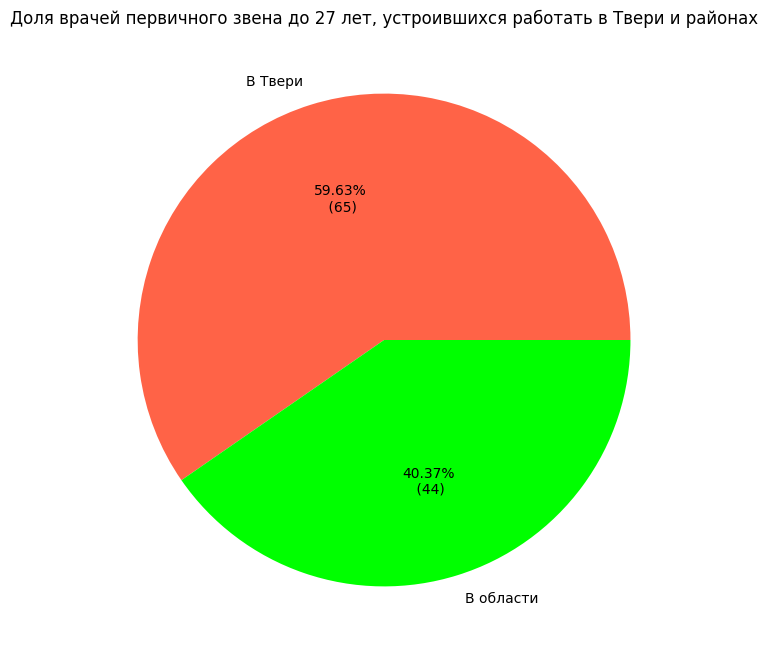

In [ ]:
plt.figure(figsize=(15,8))
clr = ['tomato', 'lime', 'yellow']
plt.pie(x = [spec27_t, spec27], labels = ['В Твери', 'В области'], colors = clr,
    autopct=lambda p : '{:.2f}%'.format(p)+'\n ({:.0f})'.format(p*(spec27_t + spec27)/100))
plt.title('Доля врачей первичного звена до 27 лет, устроившихся работать в Твери и районах')
plt.show()

**Ответ на вопрос: Верно ли, что не менее 50 выпускников Университета (24-27 лет) устроились работать в этом году в систему оказания первичной врачебной медико-санитарной помощи Твери и Тверской области? Верно ли, что в Твери выпускников Университета устроилось работать больше, чем в области?**

Невозможно ответить на эти вопросы. В предоставленных данных нет информации о том, выпускниками каких ВУЗов являются врачи и когда они трудоустроились.

Среди первичного звена 109 врачей в возрасте до 27 лет включительно - недавние выпускники мед учебных учреждений (каких именно - неизвестно). 65 из них работают в Твери, остальные в районах области.

**Промежуточный итог**

Ответили на поставленные вопросы:
- в ближних к Твери районах кадровый голод действительно больше
- в пенсионном возрасте работают только 1/3 врачей
- в интересующих возрастных группах больше женщин
- молодые специалисты и недавние выпускники работают как в Твери, так и районах

# Общий вывод

Общий вывод напишу в самом конце после всех правок / переделок =)


**Выгрузка данных для DataLens**

In [ ]:
#Преобразование полигонов в формат DataLends
def export_datalens():
  #Упрощаем полигоны
  from shapely import simplify
  for i in range(0, len(tver_pop)):
    tver_pop.loc[i, 'geometry_simplify'] = simplify(tver_pop.loc[i, 'geometry'],tolerance=0.0001,preserve_topology=True)

  #добавялем колонку с форматом полигона для DataLens
  tver_pop['dlp'] = tver_pop['geometry_simplify'].apply(bi_format)

  #меняем местами широту и долготу для DataLens
  tver_pop['dlp'] = tver_pop['dlp'].apply(lambda x: str([[lvl2[::-1] for lvl2 in lvl1] for lvl1 in eval(x)]))

  #сохранение только нужных колонок
  tver_pop_export = tver_pop.drop(['territory_id', 'geometry', 'geometry_simplify'], axis=1)
  data_export = data.drop('coord_m', axis=1)
  tver_pop_export.to_csv('tver_pop.csv', index=False)
  data_export.to_csv('tver_med.csv', index=False)
  return

#export_datalens()